# Hausarbeit Maschinelles Lernen MADS23oB Heidi Gehring, Lea Kleemann

## Eidesstattliche Erklärung
Hiermit versichere ich _________________________________,
_________________, dass ich sämtliche im
___________________________________ schriftlich
Masterstudiengang
angefertigten
Prüfungsleistungen, die ich in elektronischer oder anderer Form an der
NORDAKADEMIE vorlegen werde, ohne fremde Hilfe und ohne Benutzung anderer als der
angegebenen Hilfsmittel anfertigen werde. Die aus fremden Quellen direkt oder indirekt
übernommenen Gedanken werden als solche kenntlich gemacht. Die Arbeiten wurden bisher
in gleicher oder ähnlicher Form noch keiner anderen Prüfungskommission vorgelegt oder
veröffentlicht. Für meine Masterthesis werde ich eine gesonderte Erklärung bei der
Abgabe anfertigen und unterzeichnet in die Arbeit einbinden. 

## Problemstellung
### Gewählter Datensatz
In dieser Arbeit wird [folgender](https://www.kaggle.com/datasets/thedevastator/book-recommender-system-itembased?select=collaborative_books_df.csv) Datensatz verwendet. Dieser zielt ursprünglich auf die Entwicklung eines Recommender Systems für Buchvorschläge ab. 

Der Datensatz besteht aus Informationen über Bücher, Bewertungen und Nutzer, die von Kaggle stammen. Der Datensatz enthält Merkmale wie Buch-ID, Titel, Autor, ISBN, Genre, Bewertung, und Nutzer-ID.
### Analysefrage
Im Rahmen dieser Arbeit soll evaluiert werden, ob die vorhandenen Daten sich eignen, vorherzusagen, welche Bewertung ein Nutzer einem gegebenen Buch geben würde.
### Link zum Repository
Das für diese Arbeit genutzte GitHub-Repository ist unter [folgender](https://github.com/LeaKleemann/HA_MaschinellesLernen_MADS23oB) Adresse zu finden.

## Lösungsansatz und Projektskizze
Ziel dieser Arbeit ist, für einen Nutzer und ein Buch eine Bewertungsvorhersage analog der "Predicted Rating" aus collaborative_books_df.csv zu treffen.
Es soll kein Recommender System erstellt werden.

Im Rahmen dieser Arbeit sollen sowohl Classification- als auch Regressions-Algorithmen für diesen Anwendungsfall untersucht werden. Hier bei dienen die "Actual Rating"-Bewertungen als Target-Werte. Da diese sowohl als eine finite Anzahl Kategorien, als auch als numerische Werte aufgefasst werden können, bieten sich beide Ansätze an.

Diese Arbeit startet mit der Hypothese, dass die Nutzer anhand ihres Lese- und Bewertungsverhaltens in Lesergruppen geclustert werden können. Diese Cluster sollen anstelle der Nutzer-ID im Berwertungsvorhersagemodell als Feature verwendet werden.

Des Weiteren müssen einige Buch-Merkmale in feste Dimensionalitäten gebracht werden. Hierbei lag das Augenmerk auf den Merkmalen "description" mit dem Klappentext und "genre", welches eine Liste aus Genres, denen ein Buch angehört, beinhaltet. Für den Klappentext werden Topic-Modeling-Ansätze herangezogen und für die Genres wird One-Hot-Encoding genutzt.

## Datenexploration


In [6]:
# combining all imports for the notebook
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pathlib2 as pathlib
import numpy as np

from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import tokenize
import re

import joblib
from optuna import Trial, create_study
from optuna.pruners import SuccessiveHalvingPruner

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPRegressor

import tensorflow as tf

randomstate=313

In [7]:
# define base paths
cwd=pathlib.Path.cwd() #current working directory
datadirpath=cwd.joinpath("data") # data drectory unter current working directory
rawdatapath=datadirpath.joinpath("raw") 

# Explore collaborative_books_df.csv

In [8]:
reviewdf=pd.read_csv(rawdatapath.joinpath("collaborative_books_df.csv"))
reviewdf=reviewdf.drop([reviewdf.columns[0]],axis=1) # removed unnamed index column
print(reviewdf.columns)

Index(['title', 'book_id', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating'],
      dtype='object')


In [9]:
# print basic information
print(f"Number of observations: {len(reviewdf)}")
print(f"Number of unique book ids: {len(reviewdf["book_id"].unique())}")
print(f"Number of unique user ids: {len(reviewdf["user_id_mapping"].unique())}")
print(f"Average actual rating: {reviewdf["Actual Rating"].mean()}")
print(f"Average predicted rating: {reviewdf["Predicted Rating"].mean()}")

Number of observations: 196296
Number of unique book ids: 898
Number of unique user ids: 66909
Average actual rating: 3.922902147776827
Average predicted rating: 3.8966672779883433


<Axes: >

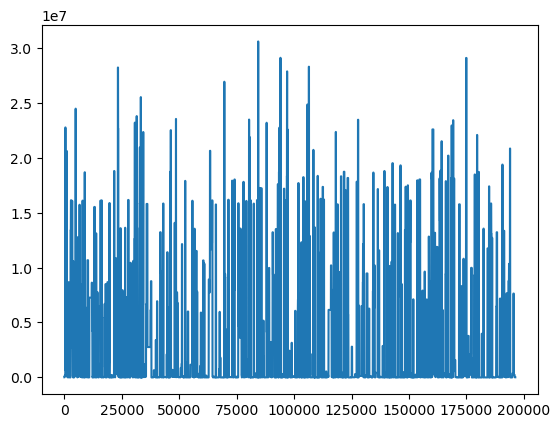

In [10]:
reviewdf["book_id"].plot() # not conclusive, try grouped by id, count as aggregate metric

In [11]:
num_books=len(reviewdf.book_id_mapping.unique())
print(f'Number of unique books: {num_books}') #898 --> that means we do not have data for all books

Number of unique books: 898


## Explore user ids

In [12]:
# groupby user id
reviewdf_userids=reviewdf[["user_id_mapping","book_id"]].groupby(by="user_id_mapping").count()
reviewdf_userids=reviewdf_userids.reset_index()
reviewdf_userids=reviewdf_userids.rename(columns={"book_id":"book_count"})

In [13]:
print(f"(repeat) Number of users: {len(reviewdf_userids)}")
print(f"Max number of books revied per user: {reviewdf_userids.book_count.max()}")
print(f"Min number of books revied per user: {reviewdf_userids.book_count.min()}")
print(f"Number of users with 1 review: {len(reviewdf_userids.query('book_count == 3'))}")
print(f"... in %: {round(len(reviewdf_userids.query('book_count == 3'))/len(reviewdf_userids),2)*100}%") # 18% is suboptimal --> prediction of score for single user is probably not going to work
print(f"Number of users with less than 6 reviews: {len(reviewdf_userids.query('book_count < 6'))}")
print(f"... in %: {round(len(reviewdf_userids.query('book_count < 6'))/len(reviewdf_userids),2)*100}%") # 90% is suboptimal

(repeat) Number of users: 66909
Max number of books revied per user: 22
Min number of books revied per user: 1
Number of users with 1 review: 12202
... in %: 18.0%
Number of users with less than 6 reviews: 59981
... in %: 90.0%


## Explore book ids

In [14]:
# groupby book_id
reviewdf_bookids=reviewdf[["book_id","user_id_mapping"]].groupby(by="book_id").count()
reviewdf_bookids=reviewdf_bookids.reset_index()
reviewdf_bookids=reviewdf_bookids.rename(columns={"user_id_mapping":"user_count"})

In [15]:
print(f"(repeat) Number of books: {len(reviewdf_bookids)}")
print(f"Max number of users reviewd per book: {reviewdf_bookids.user_count.max()}")
print(f"Min number of users reviewd per book: {reviewdf_bookids.user_count.min()}")
print(f"Number of books with 1 review: {len(reviewdf_bookids.query('user_count == 3'))}")
print(f"... in %: {round(len(reviewdf_bookids.query('user_count == 3'))/len(reviewdf_bookids),2)*100}%") # 18% is suboptimal --> prediction of score for single user is probably not going to work
print(f"Number of books with less than 6 reviews: {len(reviewdf_bookids.query('user_count < 6'))}")
print(f"... in %: {round(len(reviewdf_bookids.query('user_count < 6'))/len(reviewdf_bookids),2)*100}%") # 90% is suboptimal

(repeat) Number of books: 898
Max number of users reviewd per book: 1296
Min number of users reviewd per book: 36
Number of books with 1 review: 0
... in %: 0.0%
Number of books with less than 6 reviews: 0
... in %: 0.0%


## Explore Ratings

In [16]:
reviewvaluecountsdf=reviewdf["Actual Rating"].value_counts()
reviewssum=reviewvaluecountsdf.sum()
reviewvaluecountsdf["percentage"]=reviewvaluecountsdf.transform(func=lambda x:x/reviewssum*100,axis=0) #50+% at rating of more than 3

predvaluecountsdf=reviewdf["Predicted Rating"].value_counts()
predvaluecountsdf["percentage"]=predvaluecountsdf.transform(func=lambda x:x/reviewssum*100,axis=0)

bins=[1,2,3,4,5,6] #
hist, edges = np.histogram(reviewdf["Predicted Rating"],bins=bins,density=False)
predbinsvaluecountsdf=pd.DataFrame(hist,index=bins[:-1],columns=["PredictedRating_count"])
predbinsvaluecountsdf["percentage"]=predbinsvaluecountsdf.transform(func=lambda x:x/reviewssum*100,axis=0)

<Axes: ylabel='count'>

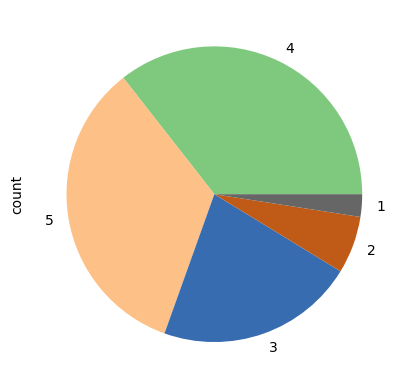

In [17]:
reviewvaluecountsdf["percentage"].plot(kind='pie',colormap='Accent')

<Axes: ylabel='percentage'>

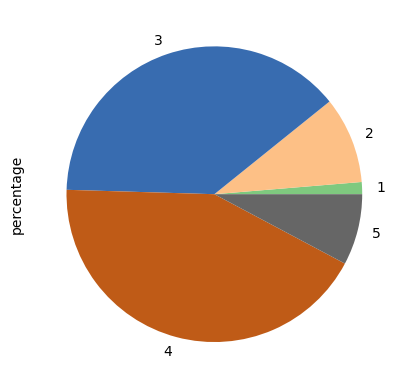

In [18]:
predbinsvaluecountsdf.percentage.plot(kind='pie',colormap='Accent')

In [19]:
print(f"Sum of reviews: {reviewssum}")

print(f"(repeat) Average actual rating: \n {reviewdf["Actual Rating"].mean()}")
print(f"Max actual rating: {reviewdf["Actual Rating"].max()}")
print(f"Min actual rating: {reviewdf["Actual Rating"].min()}")
print(f"Overview of Rating occurence: {reviewvaluecountsdf}")
print(f"... in percentage: \n {reviewvaluecountsdf["percentage"]}") # comparatively few bad reviews
print("________________ \n")
print(f"(repeat) Average predicted rating: {reviewdf["Predicted Rating"].mean()}")
print(f"Max predicted rating: {reviewdf["Predicted Rating"].max()}")
print(f"Min predicted rating: {reviewdf["Predicted Rating"].min()}")
# print(f"Overview of Rating occurence: {predvaluecountsdf}") # continuous values
# print(f"... in percentage: \n {predvaluecountsdf["percentage"]}") # continuous values, try binning
print(f"Overview of Rating occurence: \n {predbinsvaluecountsdf["PredictedRating_count"]}")
print(f"... in percentage: \n {predbinsvaluecountsdf["percentage"]}")

Sum of reviews: 196296
(repeat) Average actual rating: 
 3.922902147776827
Max actual rating: 5
Min actual rating: 1
Overview of Rating occurence: Actual Rating
4                                                         69813
5                                                         66663
3                                                         42680
2                                                         12303
1                                                          4837
percentage    Actual Rating
4    35.565167
5    33.960447
3 ...
Name: count, dtype: object
... in percentage: 
 Actual Rating
4    35.565167
5    33.960447
3    21.742674
2     6.267575
1     2.464136
Name: count, dtype: float64
________________ 

(repeat) Average predicted rating: 3.8966672779883433
Max predicted rating: 5.0
Min predicted rating: 1.0
Overview of Rating occurence: 
 1     2588
2    18588
3    76042
4    83816
5    15262
Name: PredictedRating_count, dtype: int64
... in percentage: 
 1     1.318417


# exploring collaborative_book_metadata.csv

In [20]:
booksdf=pd.read_csv(rawdatapath.joinpath('collaborative_book_metadata.csv'))
booksdf=booksdf.drop([booksdf.columns[0]],axis=1) # removed unnamed index column
print(booksdf.columns)
booksgroupbyauthorsdf=booksdf[["name","book_id_mapping"]].groupby(by="name").count()
booksgroupbyauthorsdf=booksgroupbyauthorsdf.reset_index()
booksgroupbyauthorsdf=booksgroupbyauthorsdf.rename(columns={"book_id_mapping":"book_count"})

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'genre', 'name', 'book_id_mapping'],
      dtype='object')


In [21]:
booksgroupbyauthorsdf.sort_values(by="book_count",ascending=False).head()

,name,book_count
7,Charlaine Harris,3
21,Fiona Staples,3
11,Christopher Paolini,3
22,George R.R. Martin,2
67,Robert Jordan,2


In [22]:
print(f"Number of books: {len(booksdf)}")
print("___________________ \n")
print(f"Max number of pages: {booksdf.num_pages.max()}")
print(f"Avg number of pages: {booksdf.num_pages.mean()}")
print(f"Min number of pages: {booksdf.num_pages.min()}")
print("___________________ \n")
print(f"Max number of ratings: {booksdf.ratings_count.max()}")
print(f"Avg number of ratings: {booksdf.ratings_count.mean()}")
print(f"Min number of ratings: {booksdf.ratings_count.min()}")
print("___________________ \n")
print(f"Number of unique authors: {len(booksdf.name.unique())}")
print(f"Authors with most books: {booksgroupbyauthorsdf.sort_values(by="book_count",ascending=False).head()}") #max =3, not al lot of books per author, maybe not predictive enough

Number of books: 96
___________________ 

Max number of pages: 4100
Avg number of pages: 388.96875
Min number of pages: 26
___________________ 

Max number of ratings: 1128913
Avg number of ratings: 235801.38541666666
Min number of ratings: 50020
___________________ 

Number of unique authors: 83
Authors with most books:                    name  book_count
7      Charlaine Harris           3
21        Fiona Staples           3
11  Christopher Paolini           3
22   George R.R. Martin           2
67        Robert Jordan           2


## explore genres

In [23]:
# split and process genres
booksdf['genre']=booksdf.genre.apply(lambda x: x.replace("'","")) # remove '
booksdf['genre']=booksdf.genre.apply(lambda x: x.replace("-","")) # revome - 
booksdf['genre']=booksdf.genre.apply(lambda x: x.replace(" ","")) # remove spaces
booksdf['genre']=booksdf.genre.apply(lambda x: x[1:-1].split(',')) # split into list

In [24]:
# get number of genres
booksdf["num_genres"]=booksdf.genre.apply(lambda x: len(x))

In [25]:
print(f"Max number of genres: {booksdf.num_genres.max()}")
print(f"Avg number of genres: {booksdf.num_genres.mean()}")
print(f"Min number of genres: {booksdf.num_genres.min()}")

Max number of genres: 12
Avg number of genres: 5.760416666666667
Min number of genres: 1


In [26]:
flattenedgenres=[g for sub in booksdf.genre.to_list() for g in sub]
uniquegenres=list(set(flattenedgenres))

In [27]:
print(uniquegenres)
print(f"Number of unique genres: {len(uniquegenres)}") # 16 genres: maybe too many --> sparse

['thriller', 'fantasy', 'nonfiction', 'graphic', 'comics', 'history', 'crime', 'biography', 'children', 'romance', 'youngadult', 'paranormal', 'fiction', 'poetry', 'mystery', 'historicalfiction']
Number of unique genres: 16


In [28]:
# encode genres
booksdf=booksdf.join(booksdf.genre.str.join('|').str.get_dummies())

In [29]:
genressum=booksdf[uniquegenres].sum()
genressum

thriller             28
fantasy              60
nonfiction           16
graphic              14
comics               14
history              23
crime                28
biography            23
children             20
romance              53
youngadult           66
paranormal           60
fiction              92
poetry                5
mystery              28
historicalfiction    23
dtype: int64

In [30]:
print(f"Max amount of books in genre: {genressum.max()}") # fiction, with 96 books total and 16 nonfiction? are there fiction/nonfiction books?
print(f"Avg amount of books in genre: {genressum.mean()}")
print(f"Min amount of books in genre: {genressum.min()}") # poetry only has 5 books, could be underrepresented

Max amount of books in genre: 92
Avg amount of books in genre: 34.5625
Min amount of books in genre: 5


In [31]:
contradictorygenresdf=booksdf[(booksdf['nonfiction']==1) & (booksdf['fiction']==1)]

In [32]:
print(f"Number of books both fiction and nonfiction: {len(contradictorygenresdf)}") # 12, consider removing fiction-genre?

Number of books both fiction and nonfiction: 12


## Join books_df (reviews) with book_metadata (books)

In [33]:
joinedouterdf=pd.merge(reviewdf,booksdf,left_on='book_id_mapping',right_on='book_id_mapping',how='outer')
joinedinnerdf=pd.merge(reviewdf,booksdf,left_on='book_id_mapping',right_on='book_id_mapping',how='inner')

tempdupesdf=pd.concat([joinedouterdf[['book_id_mapping','user_id_mapping']],joinedinnerdf[['book_id_mapping','user_id_mapping']]],).drop_duplicates(keep=False) # get non-matches, len 176 473 is correct length
differencedf=joinedouterdf.drop(index=tempdupesdf.index)

print(len(joinedouterdf))
print(len(joinedinnerdf))
len(joinedouterdf)-len(joinedinnerdf) # check number of non matches

print(len(differencedf))
print(len(tempdupesdf))
len(tempdupesdf)+len(differencedf) # checked with above so lengths match

tempcheckdf=joinedinnerdf.duplicated(tempdupesdf,False)
tempcheckdf.value_counts() # only False --> no dupes, code worked correctly

196297
19824
19824
176473


False    19824
Name: count, dtype: int64

## save new dataframes to csv files

In [34]:
processeddatapath=datadirpath.joinpath('processed')
try: 
    processeddatapath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')

outerjoinpath=processeddatapath.joinpath('outerJoinData.csv')
innerjoinpath=processeddatapath.joinpath('innerJoinData.csv')
differencejoinpath=processeddatapath.joinpath('differenceJoinData.csv')
dupesjoinpath=processeddatapath.joinpath('duplicatesJoinData.csv')
booksdfpath=rawdatapath.joinpath('collaborative_book_metadata_with_genredummies.csv')

Directory already exists


In [35]:
joinedouterdf.to_csv(outerjoinpath,sep=';',index=False)
joinedinnerdf.to_csv(innerjoinpath,sep=';',index=False)
differencedf.to_csv(differencejoinpath,sep=';',index=False)
tempdupesdf.to_csv(dupesjoinpath,sep=';',index=False)
booksdf.to_csv(booksdfpath,sep=';',index=False)

## Daten Clustern
### Nutzerdaten
### Topic Modeling der Buchklappentexte
### Erkenntnisse

In [36]:
dataworeviewsfile=datadirpath.joinpath('raw/collaborative_book_metadata_with_genredummies.csv')
models_path=cwd.joinpath('models')

fulldatadf=pd.read_csv(dataworeviewsfile,sep=';')
# remove previously created columns by pd.get_dummies()
fulldatadf=fulldatadf.drop(['biography', 'children', 'comics', 'crime', 'fantasy', 'fiction',
       'graphic', 'historicalfiction', 'history', 'mystery', 'nonfiction',
       'paranormal', 'poetry', 'romance', 'thriller', 'youngadult'],axis=1)

# preporcess genre string to list of genres
fulldatadf['genre']=fulldatadf.genre.apply(lambda x: x.replace("'","")) # remove '
fulldatadf['genre']=fulldatadf.genre.apply(lambda x: x.replace("-","")) # revome - 
fulldatadf['genre']=fulldatadf.genre.apply(lambda x: x.replace(" ","")) # remove spaces
fulldatadf['genre']=fulldatadf.genre.apply(lambda x: x[1:-1].split(',')) # split into list

In [37]:
# Train or Load MultiLabelBinarizer for One Hot Encoding of genres
retrain_mlb=True
mlbmodelpath=models_path.joinpath('mlb_model')
if retrain_mlb:
    xtrain,xtest=train_test_split(fulldatadf['genre'],test_size=0.1,random_state=randomstate,shuffle=True)
    mlb=MultiLabelBinarizer()
    mlbmodel=mlb.fit(xtrain)
    joblib.dump(mlbmodel,mlbmodelpath.joinpath('mlbmodel.pkl').as_posix())
else:
    mlbmodel=joblib.load(mlbmodelpath.joinpath('mlbmodel.pkl').as_posix())

newcols=mlbmodel.classes_

pred=mlbmodel.transform(fulldatadf.genre)
preddf=pd.DataFrame(pred,columns=newcols)
fulldatadf=fulldatadf.join(preddf)

## Nutzerdaten

In [38]:
#Heidi Gehring: loading user ratings and inspecting the data
user_ratings_df=pd.read_csv(rawdatapath.joinpath("collaborative_books_df.csv"))
user_ratings_df=user_ratings_df.drop([user_ratings_df.columns[0]],axis=1) # removed unnamed index column
print(user_ratings_df.columns)
print(user_ratings_df.head)

Index(['title', 'book_id', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating'],
      dtype='object')
<bound method NDFrame.head of                      title  book_id  user_id_mapping  book_id_mapping  \
0       I Am the Messenger    19057             1537              299   
1       I Am the Messenger    19057            23039              299   
2       I Am the Messenger    19057            39096              299   
3       I Am the Messenger    19057            14631              299   
4       I Am the Messenger    19057            32816              299   
...                    ...      ...              ...              ...   
196291            Coraline    17061            58417              106   
196292            Coraline    17061             9941              106   
196293            Coraline    17061            31383              106   
196294            Coraline    17061            33833              106   
196295            Coraline    17061

In [39]:
# Heidi Gehring: Count unique entries in 'user_id_mapping' to understand how many unique users there are
unique_count = user_ratings_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count}")

Number of unique entries: 66909


In [40]:
#Heidi Gehring: loading and inspecting the metadata about books
book_metadata_df=pd.read_csv(rawdatapath.joinpath("collaborative_book_metadata.csv"))
book_metadata_df=book_metadata_df.drop([book_metadata_df.columns[0]],axis=1) # removed unnamed index column
print(book_metadata_df.columns)
print(book_metadata_df.head)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'genre', 'name', 'book_id_mapping'],
      dtype='object')
<bound method NDFrame.head of      book_id                                              title  \
0    5899779  Pride and Prejudice and Zombies Pride and Prej...   
1     872333                          Blue Bloods Blue Bloods 1   
2   15507958                      Me Before You Me Before You 1   
3      66559                                      Sharp Objects   
4    7235533          The Way of Kings The Stormlight Archive 1   
..       ...                                                ...   
91  10600242                                  How to Be a Woman   
92      9516   Persepolis The Story of a Childhood Persepolis 1   
93    307791                  The City of Ember Book of Ember 1   
94     37442  Wicked The Life and Times of the Wicked Witch ...   
95  29069989  Harry Potter and the Cursed Child Parts 1 2 Ha...   

       

### Data preparation:
Merge the 2 datasets and only keep the user ratings, where we have book metadata.

Going forward the merged dataset will be explored to understand whether it is suitbable to predict how users would rate books. 

In [41]:
#Heidi Gehring: prepare data about books to be merged

# Function to clean up genre names
def clean_genre(genre):
    if pd.isna(genre):
        return ''
    genre = genre.strip()
    genre = re.sub(r"[^\w\s,]", "", genre)  # Remove any non-alphanumeric characters except commas and spaces
    genre = genre.replace("'", "")          # Remove single quotes
    genre = genre.replace("[", "")          # Remove square brackets
    genre = genre.replace("]", "")
    genre = genre.replace(",", ", ")        # Normalize spaces around commas
    return genre

# Apply the cleaning function to the genre column
book_metadata_df['cleaned_genre'] = book_metadata_df['genre'].apply(clean_genre)

# Display cleaned genres to verify
print("Cleaned Genres:")
print(book_metadata_df['cleaned_genre'].unique())


Cleaned Genres:
['fantasy,  paranormal,  romance,  fiction,  history,  historical fiction,  biography,  youngadult,  mystery,  thriller,  crime'
 'youngadult,  fantasy,  paranormal,  romance,  fiction,  mystery,  thriller,  crime'
 'romance,  fiction' 'mystery,  thriller,  crime,  fiction'
 'fantasy,  paranormal,  fiction'
 'fiction,  mystery,  thriller,  crime,  fantasy,  paranormal'
 'fantasy,  paranormal,  fiction,  history,  historical fiction,  biography'
 'fantasy,  paranormal,  fiction,  youngadult'
 'fantasy,  paranormal,  fiction,  youngadult,  romance'
 'fiction,  romance' 'fiction,  fantasy,  paranormal,  youngadult'
 'fiction,  poetry,  history,  historical fiction,  biography,  nonfiction,  romance,  youngadult'
 'fantasy,  paranormal,  fiction,  romance,  mystery,  thriller,  crime,  youngadult'
 'fantasy,  paranormal,  youngadult,  fiction,  children,  romance,  mystery,  thriller,  crime'
 'fantasy,  paranormal,  fiction,  youngadult,  children,  mystery,  thriller,  cr

Use one hot encoding to be able to use the genre information for clustering and prediction, going forward. 

In [42]:
# One-hot encoding the genre information
genre_dummies = book_metadata_df['cleaned_genre'].str.get_dummies(sep=', ')

# Combine the encoded genre information with the book metadata
book_metadata_df = pd.concat([book_metadata_df, genre_dummies], axis=1)

# Drop the original genre and cleaned_genre columns as it is no longer needed
book_metadata_df = book_metadata_df.drop(columns=['genre', 'cleaned_genre'])

# Display the book metadata and inspect the new columns
print("Processed Book Metadata DataFrame Head:")
print(book_metadata_df.head())

Processed Book Metadata DataFrame Head:
    book_id                                              title  \
0   5899779  Pride and Prejudice and Zombies Pride and Prej...   
1    872333                          Blue Bloods Blue Bloods 1   
2  15507958                      Me Before You Me Before You 1   
3     66559                                      Sharp Objects   
4   7235533          The Way of Kings The Stormlight Archive 1   

                                           image_url  \
0  https://images.gr-assets.com/books/1320449653m...   
1  https://images.gr-assets.com/books/1322281515m...   
2  https://images.gr-assets.com/books/1357108762m...   
3  https://images.gr-assets.com/books/1423241485m...   
4  https://images.gr-assets.com/books/1507307887m...   

                                                 url  num_pages  \
0  https://www.goodreads.com/book/show/5899779-pr...        320   
1  https://www.goodreads.com/book/show/872333.Blu...        302   
2  https://www.goodreads.

Heidi Gehring: regularly use print to inspect the current dataframe

In [43]:
print(book_metadata_df.columns)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'name', 'book_id_mapping', ' biography', ' children',
       ' comics', ' crime', ' fantasy', ' fiction', ' graphic',
       ' historical fiction', ' history', ' mystery', ' nonfiction',
       ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult',
       'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction',
       'poetry', 'romance', 'youngadult'],
      dtype='object')


In [44]:
#Heidi Gehring: Merge the user ratings DataFrame with the book metadata DataFrame
# Use 'book_id_mapping' as the common key, and only keep rows with metadata

# Merge the DataFrames
merged_df = pd.merge(user_ratings_df, book_metadata_df, on='book_id_mapping', how='inner')

# The 'inner' join ensures that only rows with matching 'book_id_mapping' in both DataFrames are kept.
# This automatically removes any rows from user_ratings_df that do not have corresponding metadata.

# Display the DataFrame to verify
print("Merged and Filtered DataFrame Head:")
print(merged_df.head())

Merged and Filtered DataFrame Head:
                      title_x  book_id_x  user_id_mapping  book_id_mapping  \
0  We Should All Be Feminists   22738563            64847              873   
1  We Should All Be Feminists   22738563            45548              873   
2  We Should All Be Feminists   22738563             9063              873   
3  We Should All Be Feminists   22738563            27200              873   
4  We Should All Be Feminists   22738563            41888              873   

   Predicted Rating  Actual Rating  book_id_y  \
0               4.0              5    7235533   
1               4.1              4    7235533   
2               4.5              5    7235533   
3               4.2              5    7235533   
4               4.4              5    7235533   

                                     title_y  \
0  The Way of Kings The Stormlight Archive 1   
1  The Way of Kings The Stormlight Archive 1   
2  The Way of Kings The Stormlight Archive 1   
3  The W

In [45]:
print(merged_df.shape)

(19824, 39)


In [46]:
# Count unique entries in 'column_name'
unique_count1 = merged_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count1}")

Number of unique entries: 17103


Heidi Gehring: Objective is to create 1 vector per user. This will then be used as input to create user clusters

Creating user clusters:
Intially normalized data was used, but it did not yield good results for the clusters. Then the "non-normalized" data was used. It also did not yield good results for the clusters. So it was decided to move into the prediction without clustering the users.

In [47]:
#Heidi Gehring: reduce the data to 1 vector per user for further processing

# Step 1: Create the user-item matrix combined with book metadata
user_item_with_metadata = merged_df.copy()

# Identify numeric columns (metadata columns plus genres)
numeric_columns = ['num_pages', 'ratings_count'] + [col for col in genre_dummies.columns if pd.api.types.is_numeric_dtype(genre_dummies[col])]

# Step 2: Multiply each user's rating by the corresponding numeric metadata column
# Filter out non-numeric columns from `user_item_with_metadata`
numeric_metadata_columns = [col for col in numeric_columns if col in user_item_with_metadata.columns]

# Ensure 'Actual Rating' is numeric
user_item_with_metadata['Actual Rating'] = pd.to_numeric(user_item_with_metadata['Actual Rating'], errors='coerce')

# Apply multiplication only on numeric columns
for col in numeric_metadata_columns:
    if col in user_item_with_metadata.columns:
        user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Drop non-numeric columns before aggregation
user_item_with_metadata_numeric = user_item_with_metadata[numeric_metadata_columns + ['user_id_mapping']]

# Step 3: Aggregate the vectors for each user
user_vectors = user_item_with_metadata_numeric.groupby('user_id_mapping').mean()

# Step 4: Normalize the vectors, was initially executed, and in the second iteration not. 
#user_vectors_normalized = pd.DataFrame(
 #   normalize(user_vectors, norm='l2'),
  #  index=user_vectors.index,
   # columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
#print("Aggregated and Normalized User Vectors Head:") # not needed here as it was decided to try without normalization
#print(user_vectors_normalized.head())
print(user_vectors.head())

                 num_pages  ratings_count   biography   children   comics  \
user_id_mapping                                                             
2                   1240.0       826584.0         0.0        0.0      0.0   
4                    720.0       414009.0         0.0        3.0      0.0   
7                   1164.0      1494384.0         4.0        0.0      4.0   
21                   448.0       402392.0         0.0        0.0      0.0   
23                   720.0       292370.0         0.0        0.0      0.0   

                  crime   fantasy   fiction   graphic   historical fiction  \
user_id_mapping                                                              
2                   0.0       4.0       4.0       0.0                  0.0   
4                   0.0       0.0       3.0       0.0                  0.0   
7                   0.0       0.0       4.0       4.0                  4.0   
21                  2.0       2.0       0.0       0.0                 

In [48]:
#inspect the shape of the newly created user vectors
print(user_vectors.shape)

(17103, 27)


### Clustering the users
The hypothesis was, that by creating clusters, it might be possible to then use the information for each cluster to predict user ratings. 
The result was, that no good clustering was possible. 

Some iterations in the code were tried out with the cluster range to come to a conclusion how many cllusters might be optimal.

According to the elbow method and the Silhouette method, a cluster number of 25 might already give an acceptable result, but expereimenting shows that neither with 25 nor with 75 clusters, satisfying results can be achieved. 

In [49]:
#Heidi Gehring: Define the range for the number of clusters
cluster_range = range(10, 71)  # Adjust this range if needed

Experimenting with 20, 30 and 50 cluster range, 20 was very inconclusive, 30 was better 
Looking at a range up to 50 or 75 leads to the conclusion that 25 clusters could be a good number

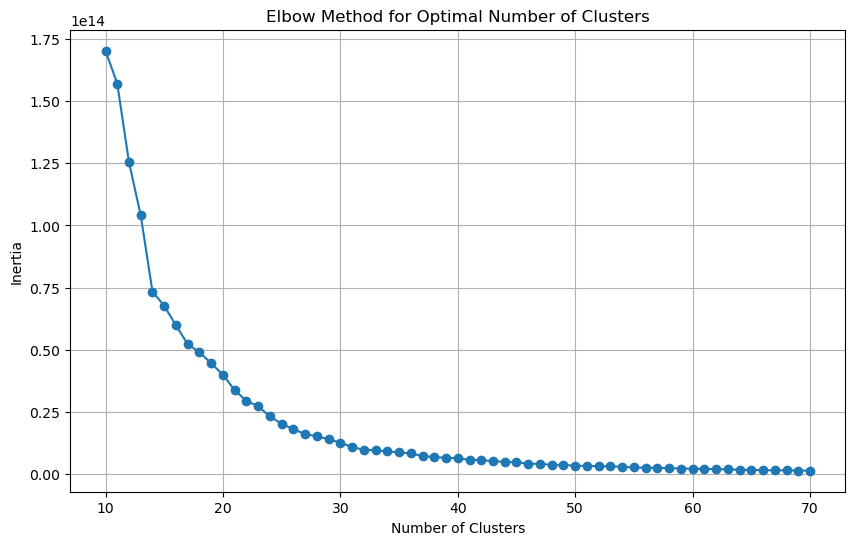

In [50]:
# elbow method to find out the right number of clusters.

# Compute K-Means for each number of clusters
inertia = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(user_vectors)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

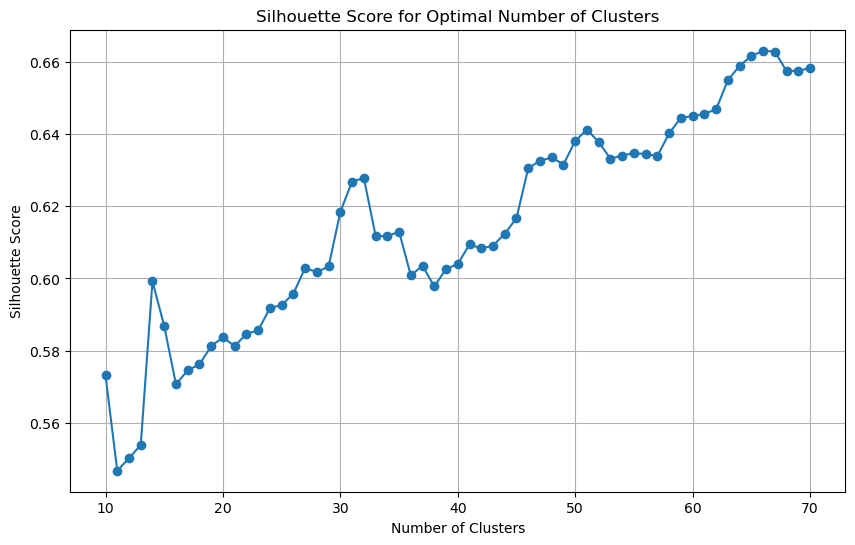

In [51]:
# silhouette score as alternative method to look at potential number of clusters

silhouette_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(user_vectors)
    silhouette_avg = silhouette_score(user_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid(True)
plt.show()

 Running several versions of elbow and silhouette method with different cluster ranges (up to 70 clusters)  leads to the initial decision to go forward with 25 clusters, as it seems to be a reasonable compromise of acceptable scores and a manageable number of clusters.

 Plotting the 25 clusters shows, that the clusters are not well separated. 

 Trying out different numbers of clusters leads to the conclusion, that with up to 70 clusters, no good separation can be achieved. 

 Both 2D and 3D Visualization were applied to inspect the outcomes. No good outcomes were achieved in any visualization.

In [52]:

# setting the number of clusters to be calculated, can be changed to experiement with different outcomes
optimal_n_clusters = 35

# Fit K-Means model with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
user_vectors['cluster'] = kmeans.fit_predict(user_vectors)

In [53]:
# Get cluster profiles
cluster_profiles = user_vectors.groupby('cluster').mean()
print(cluster_profiles)

           num_pages  ratings_count   biography   children    comics  \
cluster                                                                
0        1365.037086   3.477833e+05    0.828901   0.245124  0.233599   
1        2012.484171   1.646592e+06    1.118250   0.127095  0.058659   
2        1723.632432   2.707530e+06    0.066667   0.090090  0.000000   
3        2008.033333   4.511307e+06    0.000000   3.966667  0.000000   
4        1931.838679   7.715246e+05    0.986635   0.514702  0.271051   
5        1895.793663   1.354209e+06    1.148456   0.154952  0.063365   
6        1434.844813   2.025302e+06    1.211735   0.102891  0.020833   
7        1451.495690   3.741897e+06    0.056034   0.103448  0.000000   
8        2437.317068   9.475791e+05    1.699937   1.289818  0.829531   
9        2515.000000   5.644565e+06    0.000000   5.000000  0.000000   
10       1142.564426   6.107456e+05    0.730392   0.481092  0.177521   
11        749.645579   2.042735e+05    0.236789   0.037348  0.11

Initially the viridis color palette was used, but this is very monotonic.
A change to Paired helped the visualization in general, but not the outcome. 

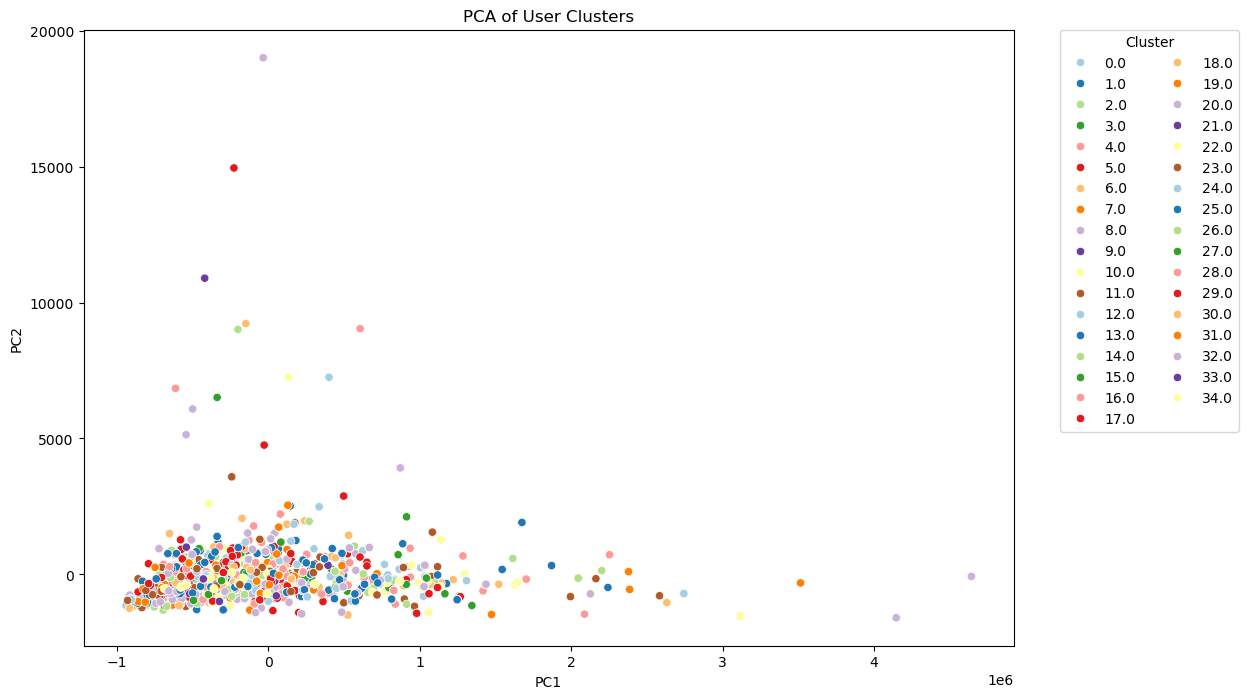

In [54]:

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_vectors['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Paired', legend='full')
plt.title('PCA of User Clusters')
# Adjust the legend to fit into the visual 
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=2)
plt.show()

In [55]:
#Creating 3d visualization, to see if this leads to a better visualization 
# # prepare data for it

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = user_vectors['cluster']

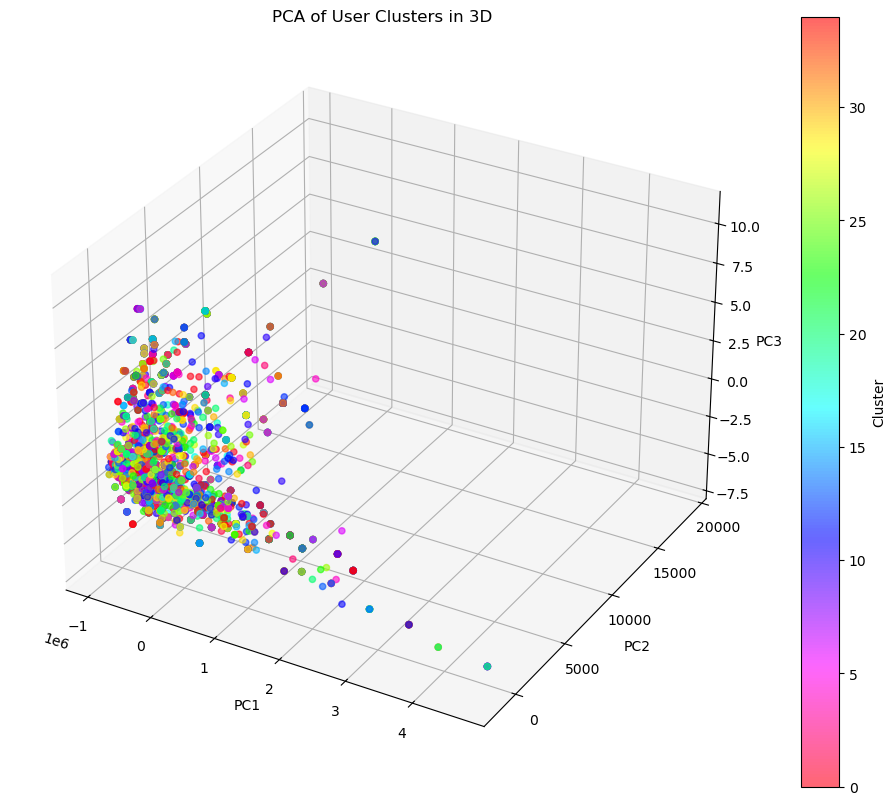

In [56]:
#create 3D scatter plot, starting with Viridis again

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['cluster'], cmap='hsv_r', alpha=0.6)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of User Clusters in 3D')

plt.show()

## Clustering with DBSCAN

As the approach using K-Means did not yield statisfying results, another approach was tried, using the DB Scan method.
In general, the same steps as for the first clusterin appraoch were followed. 

In [57]:
# Following the same steps as for K-Means Clustering, steps are repeated as normalization in step 4 is used here
# Step 1: Create the user-item matrix combined with book metadata
user_item_with_metadata = merged_df.copy()

# Identify numeric columns (metadata columns plus genre dummies)
numeric_columns = ['num_pages', 'ratings_count'] + [col for col in genre_dummies.columns if pd.api.types.is_numeric_dtype(genre_dummies[col])]

# Step 2: Multiply each user's rating by the corresponding numeric metadata column
# Filter out non-numeric columns from `user_item_with_metadata`
numeric_metadata_columns = [col for col in numeric_columns if col in user_item_with_metadata.columns]

# Ensure 'Actual Rating' is numeric
user_item_with_metadata['Actual Rating'] = pd.to_numeric(user_item_with_metadata['Actual Rating'], errors='coerce')

# Apply multiplication only on numeric columns
for col in numeric_metadata_columns:
    if col in user_item_with_metadata.columns:
        user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Drop non-numeric columns before aggregation
user_item_with_metadata_numeric = user_item_with_metadata[numeric_metadata_columns + ['user_id_mapping']]

# Step 3: Aggregate the vectors for each user
user_vectors = user_item_with_metadata_numeric.groupby('user_id_mapping').mean()

# Step 4: Normalization
user_vectors_normalized = pd.DataFrame(
   normalize(user_vectors, norm='l2'),
   index=user_vectors.index,
   columns=user_vectors.columns
)

# Step 5: Review the final user vectors
print("Aggregated and Normalized User Vectors Head:")
print(user_vectors.head())

Aggregated and Normalized User Vectors Head:
                 num_pages  ratings_count   biography   children   comics  \
user_id_mapping                                                             
2                   1240.0       826584.0         0.0        0.0      0.0   
4                    720.0       414009.0         0.0        3.0      0.0   
7                   1164.0      1494384.0         4.0        0.0      4.0   
21                   448.0       402392.0         0.0        0.0      0.0   
23                   720.0       292370.0         0.0        0.0      0.0   

                  crime   fantasy   fiction   graphic   historical fiction  \
user_id_mapping                                                              
2                   0.0       4.0       4.0       0.0                  0.0   
4                   0.0       0.0       3.0       0.0                  0.0   
7                   0.0       0.0       4.0       4.0                  4.0   
21                  2.0  

In [58]:

# Standardize the data (important for DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_vectors)

In [59]:
# Initialize DBSCAN with chosen parameters
dbscan = DBSCAN(eps=1, min_samples=5)

# Fit the model to the scaled data
dbscan.fit(X_scaled)

#  labels assigned to each data point
labels = dbscan.labels_

In [60]:
# Number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Number of noise points
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 228
Estimated number of noise points: 1646


With the parameters eps =1 und min samples = 5 a silhousett score of 0,379 was achieved, which is not satisfying.

In [61]:

# Calculate silhouette score (ignoring noise)
silhouette = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else -1
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.37976267087595283


Running the random search cv leads to the result that the parameters eps=1 and min-samples = 2 are best. 
This results in >400 clusters which is also not desired. Therefore the DB Scan clusterin method will not be explored further.

In [ ]:
#random search cv 
dbscan = DBSCAN()

param_dist = {
    'eps': np.linspace(1, 5, 5),  # setting the epsilon parameter
    'min_samples': range(2, 20)        # setting min samples to form a cluster
}


def ari_scorer(estimator, X, y_true):
    cluster_labels = estimator.fit_predict(X)
    if len(set(cluster_labels)) > 1:  # Ensure there's more than one cluster
        return adjusted_rand_score(y_true, cluster_labels)
    else:
        return -1  # Assign a low score if clustering is trivial

# Example usage in RandomizedSearchCV
ari = make_scorer(ari_scorer, needs_proba=False)



# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=dbscan,
    param_distributions=param_dist,
    n_iter=100,                   # Number of parameter settings to sample
    scoring=ari,           # Use the custom silhouette scoring function
    cv=3,                         # Number of folds (not used, but required by RandomizedSearchCV)
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_scaled)

# Best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Silhouette Score:", random_search.best_score_)

Plotting the result verifies that this is really not helpfull in moving forward.  

In [62]:
# Fit DB-Scan model 
dbscan = DBSCAN(eps=0.1, min_samples=2)

user_vectors['cluster'] = dbscan.fit_predict(user_vectors)

In [63]:
# Get cluster profiles
cluster_profiles = user_vectors.groupby('cluster').mean()
print(cluster_profiles)

           num_pages  ratings_count   biography   children    comics  \
cluster                                                                
-1       1494.978948   9.550478e+05    0.886546   0.702839  0.285074   
 0       1240.000000   8.265840e+05    0.000000   0.000000  0.000000   
 1        720.000000   4.140090e+05    0.000000   3.000000  0.000000   
 2       1164.000000   1.494384e+06    4.000000   0.000000  4.000000   
 3        448.000000   4.023920e+05    0.000000   0.000000  0.000000   
...              ...            ...         ...        ...       ...   
 528     1622.000000   1.401050e+06    2.500000   0.000000  0.000000   
 529     1147.500000   8.242700e+05    2.500000   0.000000  0.000000   
 530      328.000000   1.319310e+05    0.000000   0.000000  0.000000   
 531     1019.500000   2.050368e+06    2.000000   0.000000  0.000000   
 532      291.000000   1.864980e+05    1.000000   0.000000  0.000000   

            crime   fantasy   fiction   graphic   historical fi

Plotting the clusters that the DBScan Method is creating.
The result is not nice, and too many clusters are identified. 

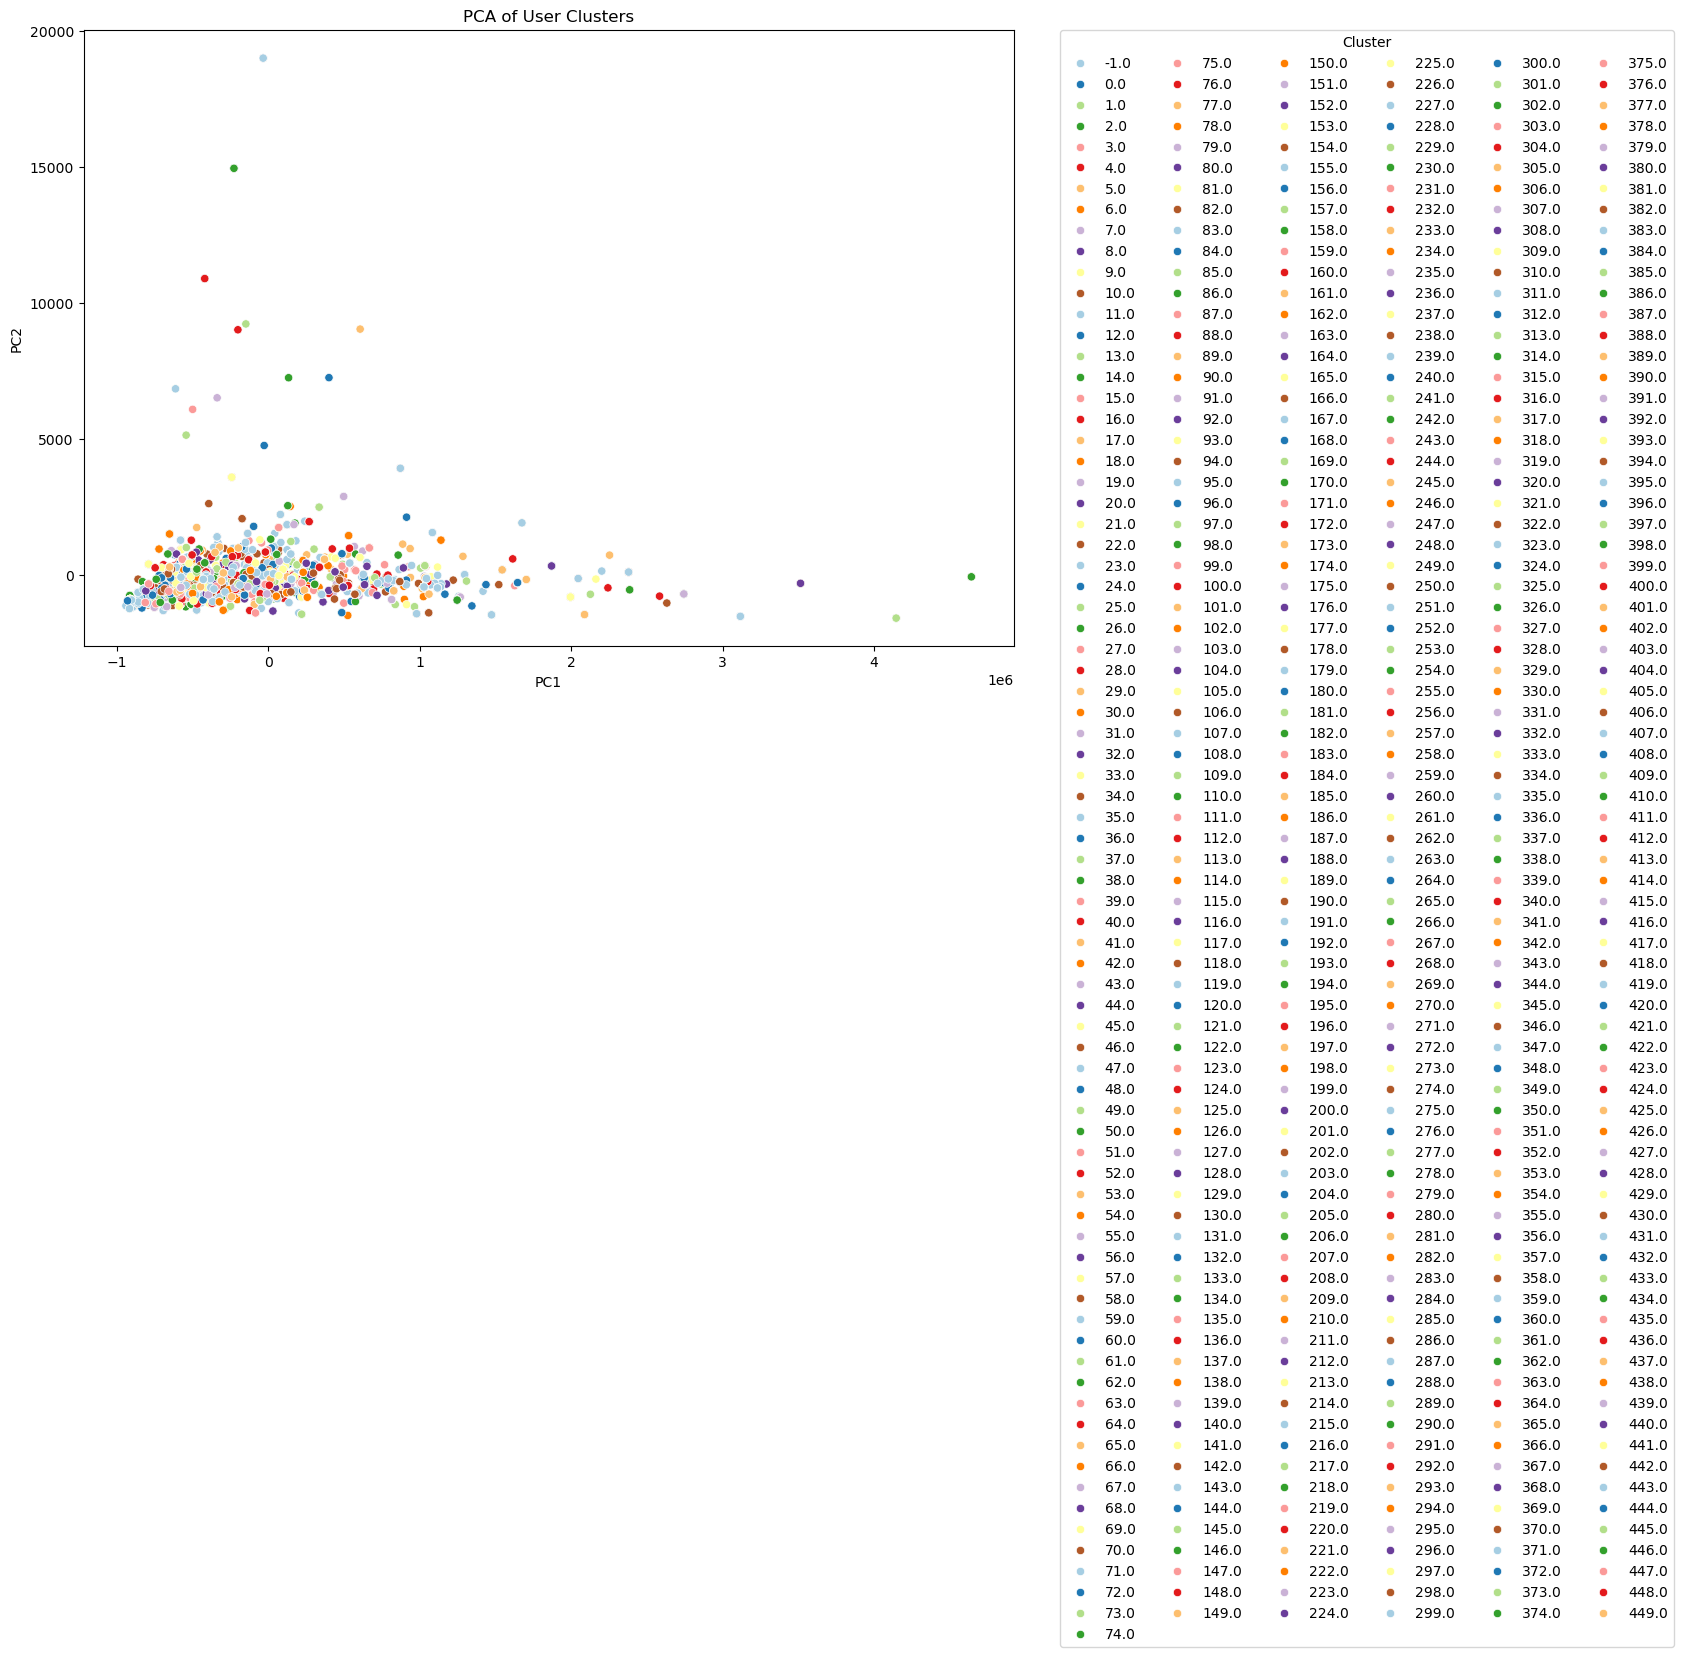

In [67]:
#initially it was viridis color palette, but that was very monotonic, changed it to Paired, still not very helpful

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_vectors['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Paired', legend='full')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=6)
plt.title('PCA of User Clusters')
plt.show()

Experimenting with 3D visualization to see if this helps to evaluate the clustering.
It verifies that no good clusters could be created, even with a very high number of clusters. 

In [69]:
# 3d visualization

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = user_vectors['cluster']

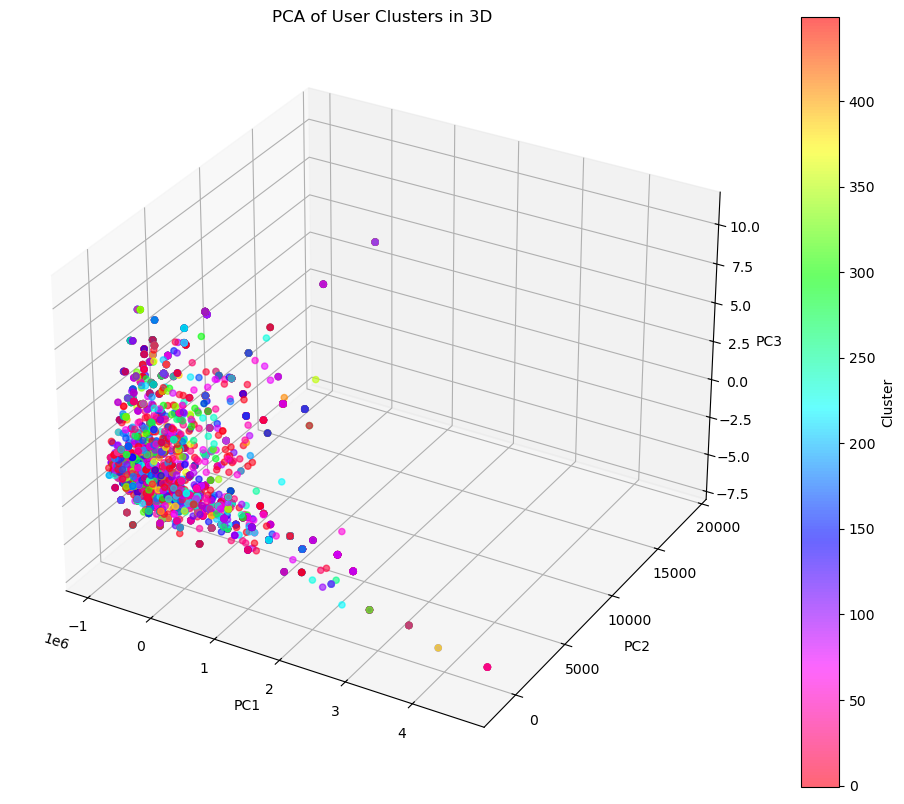

In [70]:
#create 3D scatter plot, starting with Viridis again

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['cluster'], cmap='hsv_r', alpha=0.6)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of User Clusters in 3D')

plt.show()

### Insights/ Findings
We started with the hypthesis, that creating clusters of users would be beneficial as input for the following work to predict how users or user within a certain cluster would rate a certain book.
Trying out different ways to cluster the user data and evaluating the results shows, that no good way could be found to cluster the data to use it going forward.
Therefore the decision was made to not use clusters for prediction, but use the data about the individual users and experiment with prediction based on the users directly. 

## Topic Modeling of book blurb

In [ ]:
def remove_punctuation(x):
    cleanedtext=re.sub('[^A-Za-z0-9]+', ' ', x)
    return cleanedtext

def tokenize_column(column): # this function tests gesim tokenize function used in vectorizer, not used
    l=[]
    for x in range(len(column)):
        l.append(list(tokenize(column.iloc[x])))
    return l

fulldatadf['description']=fulldatadf.description.transform(remove_punctuation)
# fulldatadf['description_list']=tokenize_column(fulldatadf.description)
# fulldatadf['description_list']

In [ ]:
# xtrain,xtest=train_test_split(fulldatadf['description'],test_size=0.1,random_state=randomstate,shuffle=True)

## group books via blurb content
- vectorize, topics via topic modeling
-  tfidf -> lda
    - evaluate via topic coherence
- https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Evaluate%20Topic%20Models.ipynb
- https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
- https://learn-scikit.oneoffcoder.com/optuna.html
- https://learn-scikit.oneoffcoder.com/gensim.html
- https://stackoverflow.com/questions/60613532/how-do-i-calculate-the-coherence-score-of-an-sklearn-lda-model

In [ ]:
def topiccoherencescorer(pipe):
    n_top_words = 10 #higher value for higher coherence, i.e. more word to make connections for coherence
    topics=pipe.named_steps['lda'].components_
    # texts=[[word for word in doc.split()] for doc in X]
    # texts=X
    texts=list(pipe.named_steps['vectorizer'].vocabulary_.keys())
    dictionary=corpora.Dictionary(texts)
    corpus=[dictionary.doc2bow(text) for text in texts]
    feature_names = [dictionary[i] for i in range(len(dictionary))]
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    cm = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v') #other coherence metrics possible, sticking with c_v
    return cm.get_coherence()

### optima study for tfidf+lda

In [ ]:
retrain_studydescription_tfidflda=True
studyname='description_tfidflda_study'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')
if retrain_studydescription_tfidflda:
    xtrain,xtest=train_test_split(fulldatadf['description'],test_size=0.1,random_state=randomstate,shuffle=True)
    xtrain,xtest=xtrain.reset_index(drop=True),xtest.reset_index(drop=True) #kf.split() needs reset index; if drop=False, index turned into new column
    

    def inst_tfidf(trial:Trial)->TfidfVectorizer:
        params={
            'norm':trial.suggest_categorical('norm',['l1','l2', None]),
            'smooth_idf':trial.suggest_categorical('smooth_idf',[True,False]),
            'sublinear_tf':trial.suggest_categorical('sublinear_tf',[True,False]),
            'stop_words':trial.suggest_categorical('stop_words',['english',list(STOPWORDS)]),
            'tokenizer':tokenize,
            # 'max_df':trial.suggest_float('max_df',0,1),
            # 'min_df':trial.suggest_float('min_df',0,1),
            # 'max_features':trial.suggest_categorical('max_features',[None,100,50,25,10]) #can't use int, because of None, PS: no max features, filters out too many words
            }
        return TfidfVectorizer(**params)
    def inst_lda(trial:Trial)->LatentDirichletAllocation:
        params={
            'n_components':trial.suggest_int('n_components',3,20),
            'learning_method':trial.suggest_categorical('learning_method',['batch','online']),
            'learning_decay':trial.suggest_float('learning_decay',0.5,0.9),
            'learning_offset':trial.suggest_float('learning_offset',2,20),
            'max_iter':trial.suggest_int('max_iter',2,20),
            'batch_size':trial.suggest_int('batch_size',5,20),
            'max_doc_update_iter':trial.suggest_int('max_doc_update_iter',0,10),
            'n_jobs':-1,
            'random_state':randomstate
        }
        return LatentDirichletAllocation(**params)
    def inst_pipeTFLDA(trial:Trial)->Pipeline:
        pipeline=Pipeline([
            ('tfidf',inst_tfidf(trial)),
            ('lda',inst_lda(trial))
        ])
        return pipeline

    def objective(trial:Trial,xtrain:pd.DataFrame)->float:
        kf = KFold(n_splits=5, shuffle=True, random_state=randomstate)
        model=inst_pipeTFLDA(trial)
        scores=[]
        for x in kf.split(xtrain):
            subxtrain=xtrain.loc[x[0]]

            pipe=model.fit(subxtrain)
            score=topiccoherencescorer(pipe) #no cv, as scorer not compatible
            scores.append(score)
        
        # scores = cross_val_score(model, x, cv=kf) #using default scorer --> approx log-likelohood
        # return np.min([np.mean(scores), np.median(scores)])
        return np.mean(scores)
    storage=thismodelpath.joinpath("description_tfidflda_study.db")
    if storage.exists():
        storage.unlink()
    else:
        print("No sqlite db found")

    study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
    study.optimize(lambda trial: objective(trial,xtrain),n_trials=100,n_jobs=-1,show_progress_bar=True)
    joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

    model = inst_pipeTFLDA(study.best_trial)
    fitpipe=model.fit(fulldatadf.description)
    joblib.dump(fitpipe,thismodelpath.joinpath(f'fittedpipelinedefault.pkl').as_posix())

else:
    fitpipe=joblib.load(thismodelpath.joinpath(f'fittedpipelinedefault.pkl').as_posix())




In [ ]:
n_top_words = 10 
topics=fitpipe.named_steps['lda'].components_
texts=list(fitpipe.named_steps['vectorizer'].vocabulary_.keys())
dictionary=corpora.Dictionary(texts)
corpus=[dictionary.doc2bow(text) for text in texts]
feature_names = [dictionary[i] for i in range(len(dictionary))]
top_words = []
for topic in topics:
    top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

top_words # topics look the same, switch to count vectorizer instead of tfidf?, more preprocessing

### optima study for cv+lda

In [ ]:
retrain_studydescription_countveclda=True

studyname='description_countlda_study'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')
if retrain_studydescription_countveclda:
    xtrain,xtest=train_test_split(fulldatadf['description'],test_size=0.1,random_state=randomstate,shuffle=True)
    xtrain,xtest=xtrain.reset_index(drop=True),xtest.reset_index(drop=True) #kf.split() needs reset index; if drop=False, index turned into new column

    def inst_countvec(trial:Trial)->CountVectorizer:
        params={
            'stop_words':trial.suggest_categorical('stop_words',['english',list(STOPWORDS)]),
            'tokenizer':tokenize,
            # 'max_df':trial.suggest_float('max_df',0,1),
            # 'min_df':trial.suggest_float('min_df',0,1),
            # 'max_features':trial.suggest_categorical('max_features',[None,100,50,25,10]) #can't use int, because of None; do not set! will filter too many words
            }
        return CountVectorizer(**params)
    def inst_lda(trial:Trial)->LatentDirichletAllocation:
        params={
            'n_components':trial.suggest_int('n_components',3,20),
            'learning_method':trial.suggest_categorical('learning_method',['batch','online']),
            'learning_decay':trial.suggest_float('learning_decay',0.5,0.9),
            'learning_offset':trial.suggest_float('learning_offset',2,20),
            'max_iter':trial.suggest_int('max_iter',2,20),
            'batch_size':trial.suggest_int('batch_size',5,20),
            'max_doc_update_iter':trial.suggest_int('max_doc_update_iter',0,10),
            'n_jobs':-1,
            'random_state':randomstate
        }
        return LatentDirichletAllocation(**params)
    def inst_pipeTFLDA(trial:Trial)->Pipeline:
        pipeline=Pipeline([
            ('countvectorizer',inst_countvec(trial)),
            ('lda',inst_lda(trial))
        ])
        return pipeline

    def objective(trial:Trial,x:pd.DataFrame)->float:
        kf = KFold(n_splits=5, shuffle=True, random_state=randomstate)
        model=inst_pipeTFLDA(trial)
        scores=[]
        for x in kf.split(xtrain):
            subxtrain=xtrain.loc[x[0]]

            pipe=model.fit(subxtrain)
            score=topiccoherencescorer(pipe) #no cv, as scorer not compatible
            scores.append(score)
            
            # scores = cross_val_score(model, x, cv=kf) #using default scorer --> approx log-likelohood
        # return np.min([np.mean(scores), np.median(scores)])
        return np.mean(scores)

    storage=thismodelpath.joinpath("description_countveclda_studydefault.db")
    if storage.exists():
        storage.unlink()
    else:
        print("No sqlite db found")

    study2=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
    study2.optimize(lambda trial: objective(trial,xtrain),n_trials=100,n_jobs=-1,show_progress_bar=True)
    joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

    model = inst_pipeTFLDA(study.best_trial)
    fitpipe=model.fit(fulldatadf.description)
    joblib.dump(fitpipe,thismodelpath.joinpath(f'fittedpipelinedefault2.pkl').as_posix())
else:
    fitpipe=joblib.load(thismodelpath.joinpath(f'fittedpipelinedefault2.pkl').as_posix())

In [ ]:
n_top_words = 10 
topics=fitpipe.named_steps['lda'].components_
texts=list(fitpipe.named_steps['vectorizer'].vocabulary_.keys())
dictionary=corpora.Dictionary(texts)
corpus=[dictionary.doc2bow(text) for text in texts]
feature_names = [dictionary[i] for i in range(len(dictionary))]
top_words = []
for topic in topics:
    top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

top_words

## lda with gridsearchcv and nmf as alternative

In [ ]:
# optimizing all hyperparameters makes script run endlessly, does not converge
# no max features for vectorizers
# nmf has no scorer, no further tries, as to focus on lda
retrain_tfidflda=True
retrain_cvlda=True

cv=CountVectorizer(tokenizer=tokenize)
tfidf=TfidfVectorizer(tokenizer=tokenize)
lda=LatentDirichletAllocation(n_jobs=-1,random_state=randomstate)
nmf=NMF(random_state=randomstate)
paramgrida={'vectorizer__stop_words':['english',list(STOPWORDS)],
            # 'vectorizer__max_features':[None,100,50],
            'lda__n_components':[3,5],
            # 'lda__learning_method':['batch','online'],
            # 'lda__learning_decay':[0.5,0.9,0.7],
            # 'lda__learning_offset':[2,10],
            # 'lda__max_iter':[2,10],
            # 'lda__batch_size':[10,50],
            # 'lda__max_doc_update_iter':[1,5]
            }
pipelinea=Pipeline([('vectorizer', cv),('lda',lda)])
paramgridb={'vectorizer__norm':['l1','l2', None],
            'vectorizer__smooth_idf':[True,False],
            'vectorizer__sublinear_tf':[True,False],
            'vectorizer__stop_words':['english',list(STOPWORDS)],
            # 'vectorizer__max_features':[None,100,50],
            'lda__n_components':[3,5],
            # 'lda__learning_method':['batch','online'],
            # 'lda__learning_decay':[0.5,0.9,0.7],
            # 'lda__learning_offset':[2,10],
            # 'lda__max_iter':[2,10],
            # 'lda__batch_size':[10,50],
            # 'lda__max_doc_update_iter':[1,5]
            }
pipelineb=Pipeline([('vectorizer', tfidf),('lda',lda)])
#nmf has no scorer, can't be optimized unless specified
# paramgridc={'nmf__n_components':['auto',None,5,10,25,50,100],
#             'nmf__init':['random', 'nndsvd', 'nndsvda', 'nndsvdar'],
#             # 'nmf__solver':['cd','mu'],
#             # 'nmf__beta_loss':['frobenius', 'kullback-leibler', 'itakura-saito'],
#             # 'nmf__tol':[0.001,0.01,0.003,0.03],
#             # 'nmf__max_iter':[20,50,100,200],
#             # 'nmf__alpha_W':[0.0,0.5,1],
#             # 'nmf__alpha_H':[0.0,0.5,1],
#             # 'nmf__l1_ratio':[0.0,0.25,0.5],
#             # 'nmf__shuffle':[True,False],
#             'vectorizer__stop_words':['english',list(STOPWORDS)],
#             'vectorizer__max_features':[None,100,50,25,10]
#             }
# pipelinec=Pipeline([('vectorizer', cv),('nmf',nmf)])
# paramgridd={'nmf__n_components':['auto',None,5,10,25,50,100],
#             'nmf__init':['random', 'nndsvd', 'nndsvda', 'nndsvdar'],
#             # 'nmf__solver':['cd','mu'],
#             # 'nmf__beta_loss':['frobenius', 'kullback-leibler', 'itakura-saito'],
#             # 'nmf__tol':[0.001,0.01,0.003,0.03],
#             # 'nmf__max_iter':[20,50,100,200],
#             # 'nmf__alpha_W':[0.0,0.5,1],
#             # 'nmf__alpha_H':[0.0,0.5,1],
#             # 'nmf__l1_ratio':[0.0,0.25,0.5],
#             # 'nmf__shuffle':[True,False],
#             'vectorizer__norm':['l1','l2', None],
#             'vectorizer__smooth_idf':[True,False],
#             'vectorizer__sublinear_tf':[True,False],
#             'vectorizer__stop_words':['english',list(STOPWORDS)],
#             'vectorizer__max_features':[None,100,50,25,10]
#             }
# pipelined=Pipeline([('vectorizer', tfidf),('nmf',nmf)])
descriptionmodelspath=models_path.joinpath('description_models')

xtrain,xtest=train_test_split(fulldatadf['description'],test_size=0.1,random_state=randomstate,shuffle=True)
if retrain_cvlda:
    gridsearcha=GridSearchCV(pipelinea,paramgrida,n_jobs=-1,cv=5,return_train_score=True)
    gridamodel=gridsearcha.fit(xtrain)
    joblib.dump(gridamodel,descriptionmodelspath.joinpath('gridamodel.pkl').as_posix())
else:
    gridamodel=joblib.load(descriptionmodelspath.joinpath('gridamodel.pkl').as_posix())

if retrain_tfidflda:
    gridsearchb=GridSearchCV(pipelineb,paramgridb,n_jobs=-1,cv=5,return_train_score=True)
    gridbmodel=gridsearchb.fit(xtrain)
    joblib.dump(gridbmodel,descriptionmodelspath.joinpath('gridbmodel.pkl').as_posix())
else:
    gridbmodel=joblib.load(descriptionmodelspath.joinpath('gridbmodel.pkl').as_posix())

# gridsearchc=GridSearchCV(pipelinec,paramgridc,n_jobs=-1,cv=5,return_train_score=True)
# gridcmodel=gridsearchc.fit(xtrain)
# joblib.dump(gridcmodel,descriptionmodelspath.joinpath('gridcmodel.pkl').as_posix())

# gridsearchd=GridSearchCV(pipelined,paramgridd,n_jobs=-1,cv=5,return_train_score=True)
# griddmodel=gridsearchd.fit(xtrain)
# joblib.dump(griddmodel,descriptionmodelspath.joinpath('griddmodel.pkl').as_posix())


## Insights and Findings

## Predicting user ratings
 - based on context information about books 
 - based on information about users that have rated 
 - Insights and Findings 

## Predicting ratings based on context information about books

In [ ]:
datawreviewsfile=datadirpath.joinpath('processed/innerJoinData.csv')
datadf=pd.read_csv(datawreviewsfile,sep=';')

datadf=datadf.drop(['biography', 'children', 'comics', 'crime', 'fantasy', 'fiction',
       'graphic', 'historicalfiction', 'history', 'mystery', 'nonfiction',
       'paranormal', 'poetry', 'romance', 'thriller', 'youngadult'],axis=1)


datadf['description']=datadf.description.transform(remove_punctuation)
datadf['genre']=datadf.genre.apply(lambda x: x.replace("'","")) # remove '
datadf['genre']=datadf.genre.apply(lambda x: x.replace("-","")) # revome - 
datadf['genre']=datadf.genre.apply(lambda x: x.replace(" ","")) # remove spaces
datadf['genre']=datadf.genre.apply(lambda x: x[1:-1].split(',')) # split into list


mlbmodelpath=models_path.joinpath('mlb_model')
mlbmodel=joblib.load(mlbmodelpath.joinpath('mlbmodel.pkl').as_posix())
newcols=mlbmodel.classes_
pred=mlbmodel.transform(datadf.genre)
preddf=pd.DataFrame(pred,columns=newcols)
datadf=datadf.join(preddf)

descriptionmodelpath=models_path.joinpath('description_models')
descmodel=joblib.load(descriptionmodelpath.joinpath('gridamodel.pkl').as_posix())
newcols=descmodel.best_estimator_.named_steps['lda'].get_feature_names_out()
pred=descmodel.best_estimator_.transform(datadf.description)
preddf=pd.DataFrame(pred,columns=newcols)
datadf=datadf.join(preddf)

In [ ]:
# datadf.head()
datadf.columns

In [ ]:
# drop columns not for prediction
# copied list:
# ['title_x','book_id_x','book_id_mapping','Predicted Rating','book_id_y', 'title_y', 'image_url', 'url','description', 'genre','num_genres']
# keep:'user_id_mapping' for user identification --> would be replaced by cluster representation, concern: as a numerical value implies false relationship between values
# target: 'Actual Rating'
dropcols=['title_x','book_id_x','book_id_mapping','Predicted Rating','book_id_y', 'title_y', 'image_url', 'url','description', 'genre','num_genres','name'] #drop author name too, as binarization too big and few duplicates
datadf=datadf.drop(dropcols,axis=1)

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(datadf.drop(['Actual Rating'],axis=1),datadf['Actual Rating'],test_size=0.1,random_state=randomstate,shuffle=True)
print(len(xtrain), len(ytrain))
print(len(xtest),len(ytest))
xtrain.dtypes

## Regression

In [ ]:
predictionmodelpath=models_path.joinpath('prediction_models')

In [ ]:
modela=svm.SVR(max_iter=150)
paramsa={'kernel':['linear','poly','rbf','sigmoid'],
         'degree':[3,4],
         'gamma':['auto','scale'],
         'coef0':[0.0,0.5,1],
         'tol':[0.001,0.003,0.01],
         'C':[1.0,0.5,2.0],
         'epsilon':[0.1,0.5],
         'shrinking':[True,False]
         }
grida=GridSearchCV(modela,paramsa,n_jobs=-1,cv=5,return_train_score=True)

modelb=DecisionTreeRegressor(random_state=randomstate)
paramsb={'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
         'splitter':['best','random'],
         'max_depth':[None,5,10],
         'min_samples_split':[2,25,100],
         'min_samples_leaf':[1,100,50],
         'max_features':[None,'log2',5],
         'max_leaf_nodes':[None,10,20],
         'ccp_alpha':[0.0,0.2,0.5]
         }
gridb=GridSearchCV(modelb,paramsb,n_jobs=-1,cv=5,return_train_score=True)

In [ ]:
retrain_svr=True
retrain_regtree=True
if retrain_svr:
    regsvmmodel=grida.fit(xtrain,ytrain)
    joblib.dump(regsvmmodel,predictionmodelpath.joinpath('regsvmmodel.pkl').as_posix())
else:
    regsvmmodel=joblib.load(predictionmodelpath.joinpath('regsvmmodel.pkl').as_posix())
if retrain_regtree:
    regdtmodel=gridb.fit(xtrain,ytrain)
    joblib.dump(regdtmodel,predictionmodelpath.joinpath('regdtmodel.pkl').as_posix())
else:
    regdtmodel=joblib.load(predictionmodelpath.joinpath('regdtmodel.pkl').as_posix())

## Classification

In [ ]:
modelc=SVC(max_iter=150,random_state=randomstate)
paramsc={
    'C':[1.0,0.5,2.0],
    'kernel':['linear','poly','rbf','sigmoid'],
    'degree':[3,4],
    'gamma':['auto','scale'],
    'coef0':[0.0,0.5,1],
    'tol':[0.001,0.003,0.01],
    'shrinking':[True,False],
    'decision_function_shape':['ovo','ovr']
}
gridc=GridSearchCV(modelc,paramsc,n_jobs=-1,cv=5,return_train_score=True)

modeld=DecisionTreeClassifier(random_state=randomstate)
paramsd={
    'criterion':['gini','entropy','log_loss'],
    'splitter':['best','random'],
    'max_depth':[None,5,10],
    'min_samples_split':[2,25,100],
    'min_samples_leaf':[1,100,50],
    'max_features':[None,'log2',5],
    'max_leaf_nodes':[None,10,20],
    'ccp_alpha':[0.0,0.2,0.5]    
}
gridd=GridSearchCV(modeld,paramsd,n_jobs=-1,cv=5,return_train_score=True)

In [ ]:
retrain_svm=True
retrain_clastree=True
if retrain_svm:
    classvmmodel=gridc.fit(xtrain,ytrain)
    joblib.dump(classvmmodel,predictionmodelpath.joinpath('classsvmmodel.pkl').as_posix())
else:
    classvmmodel=joblib.load(predictionmodelpath.joinpath('classsvmmodel.pkl').as_posix())

if retrain_clastree:
    clasdtmodel=gridd.fit(xtrain,ytrain)
    joblib.dump(clasdtmodel,predictionmodelpath.joinpath('clasdtmodel.pkl').as_posix())
else:
    clasdtmodel=joblib.load(predictionmodelpath.joinpath('clasdtmodel.pkl').as_posix())

### evaluate models

In [ ]:
predregsvm=regsvmmodel.predict(xtest)
predregdt=regdtmodel.predict(xtest)

msesvm=mean_squared_error(ytest,predregsvm)
msedt=mean_squared_error(ytest,predregdt)
r2svm=r2_score(ytest,predregsvm)
r2dt=r2_score(ytest,predregdt)

In [ ]:
print(f'MSE SVM: {msesvm}, MSE DT: {msedt}')
print(f'R2 SVM: {r2svm}, R2 DT: {r2dt}')

In [ ]:
predclassvm=classvmmodel.predict(xtest)
predclasdt=clasdtmodel.predict(xtest)

accsvm=accuracy_score(ytest,predclassvm)
accdt=accuracy_score(ytest,predclasdt)
msesvm2=mean_squared_error(ytest,predclassvm)
msedt2=mean_squared_error(ytest,predclasdt)

In [ ]:
print(f'Accuracy SVM: {accsvm}, Accuracy DT: {accdt}')
print(f'MSE SVM: {msesvm2}, MSE DT: {msedt2}')

## Regression and Classification NN

In [ ]:
retrain_studyregression=True
xtrain,xtest,ytrain,ytest=train_test_split(datadf.drop(['Actual Rating'],axis=1),datadf['Actual Rating'],test_size=0.1,random_state=randomstate,shuffle=True)
xtrain,xtest,ytrain,ytest=xtrain.reset_index(drop=True),xtest.reset_index(drop=True),ytrain.reset_index(drop=True),ytest.reset_index(drop=True) #kf.split() needs reset index; if drop=False, wird index zu neuer Spalte
studyname='prediction_regression'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')

if retrain_studyregression:
    def init_regmodel(trial):
        # model definition
        nlayers=trial.suggest_int('n_layers',1,10)
        model=tf.keras.Sequential()
        activation=trial.suggest_categorical('activation',['relu','tanh','sigmoid'])
        inputshape=xtrain.shape[1]
        model.add(tf.keras.layers.Dense(16, input_shape=(inputshape,),activation=activation))
        for i in range(nlayers):
            numhidden=trial.suggest_int(f'n_units_l{i}',32,128,log=True)
            model.add(tf.keras.layers.Dense(units=numhidden,activation=activation,name=f'layer{i}'))
        model.add(tf.keras.layers.Dense(units=1,activation='linear'))
        model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
        return model

    def reg_objective(trial:Trial,xtrain:pd.DataFrame,ytrain:pd.Series)->float:
        kf = KFold(n_splits=5, shuffle=True, random_state=randomstate)
        model=init_regmodel(trial)
        # training and evaluation
        msetest=[]
        for train,test in kf.split(xtrain):
            trdata=tf.convert_to_tensor(xtrain.loc[train])
            trlabel=tf.convert_to_tensor(ytrain.loc[train])
            evdata=tf.convert_to_tensor(xtrain.loc[test])
            evlabel=tf.convert_to_tensor(ytrain.loc[test])




            model.fit(trdata,trlabel,validation_split=0.1,epochs=10, batch_size=128,verbose=0) #more verbosity seems to crash in execution
            
            loss,mse=model.evaluate(evdata, evlabel)
            # predtrain=tmodel.predict(evdata)
            # mse=tf.keras.losses.MSE(evlabel, predtrain)
            msetest.append(mse)
        
        return np.mean(msetest)

    storage=thismodelpath.joinpath(f"{studyname}.db")
    if storage.exists():
        storage.unlink()
    else:
        print("No sqlite db found")

    study=create_study(study_name=studyname,direction='minimize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False)
    study.optimize(lambda trial: reg_objective(trial,xtrain,ytrain),n_trials=20,n_jobs=-1,show_progress_bar=True)

    joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

    regmodel = init_regmodel(study.best_trial)
    regmodel.fit(tf.convert_to_tensor(xtrain),tf.convert_to_tensor(ytrain),validation_split=0.1,epochs=10, batch_size=128,verbose=0)
    regmodel.save(thismodelpath.joinpath(f'fmodel_reg.h5').as_posix())
    
else:
    regmodel = tf.keras.models.load_model(thismodelpath.joinpath(f'fmodel_reg.h5').as_posix())

In [ ]:
retrain_studyclassification=True
xtrain,xtest,ytrain,ytest=train_test_split(datadf.drop(['Actual Rating'],axis=1),datadf['Actual Rating'],test_size=0.1,random_state=randomstate,shuffle=True)
xtrain,xtest,ytrain,ytest=xtrain.reset_index(drop=True),xtest.reset_index(drop=True),ytrain.reset_index(drop=True),ytest.reset_index(drop=True)

studyname='prediction_classification'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')
if retrain_studyclassification:
    def init_clasmodel(trial):
        # model definition
        nlayers=trial.suggest_int('n_layers',1,10)
        model=tf.keras.Sequential()
        activation=trial.suggest_categorical('activation',['relu','tanh','sigmoid'])
        inputshape=xtrain.shape[1]
        model.add(tf.keras.layers.Dense(16, input_shape=(inputshape,),activation=activation))
        for i in range(nlayers):
            numhidden=trial.suggest_int(f'n_units_l{i}',32,128,log=True)
            model.add(tf.keras.layers.Dense(units=numhidden,activation=activation,name=f'layer{i}'))
        model.add(tf.keras.layers.Dense(units=5,activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def clas_objective(trial:Trial,xtrain:pd.DataFrame,ytrain:pd.Series)->float:
        kf = KFold(n_splits=5, shuffle=True, random_state=randomstate)
        ytrain=datadf['Actual Rating'].apply(lambda x: x-1)
        model=init_clasmodel(trial)
        # training and evaluation
        acctest=[]
        for train,test in kf.split(xtrain):
            trdata=tf.convert_to_tensor(xtrain.loc[train])
            trlabel=tf.convert_to_tensor(tf.keras.utils.to_categorical(ytrain.loc[train],num_classes=5))
            evdata=tf.convert_to_tensor(xtrain.loc[test])
            evlabel=tf.convert_to_tensor(tf.keras.utils.to_categorical(ytrain.loc[test],num_classes=5))




            model.fit(trdata,trlabel,validation_split=0.1,epochs=10, batch_size=128,verbose=0) #more verbosity seems to crash in execution
            
            loss,acc=model.evaluate(evdata, evlabel)
            # predtrain=tmodel.predict(evdata)
            # mse=tf.keras.losses.MSE(evlabel, predtrain)
            acctest.append(acc)
        
        return np.mean(acctest)

    storage=thismodelpath.joinpath(f"{studyname}.db")
    if storage.exists():
        storage.unlink()
    else:
        print("No sqlite db found")

    study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False)
    study.optimize(lambda trial: clas_objective(trial,xtrain,ytrain),n_trials=20,n_jobs=-1,show_progress_bar=True)

    joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

    classmodel = init_clasmodel(study.best_trial)
    ytrain=datadf['Actual Rating'].apply(lambda x: x-1)
    classmodel.fit(tf.convert_to_tensor(xtrain),tf.convert_to_tensor(tf.keras.utils.to_categorical(ytrain,num_classes=5)),validation_split=0.1,epochs=10, batch_size=128,verbose=0)
    classmodel.save(thismodelpath.joinpath(f'fmodel_clas.h5').as_posix())
else:
    classmodel=tf.keras.models.load_model(thismodelpath.joinpath(f'fmodel_clas.h5').as_posix())

## Compare models to Predicted Rating

In [ ]:
datadf=pd.read_csv(datawreviewsfile,sep=';')
# fulldatadf=pd.read_csv(dataworeviewsfile,sep=';')
datadf=datadf.drop(['biography', 'children', 'comics', 'crime', 'fantasy', 'fiction',
       'graphic', 'historicalfiction', 'history', 'mystery', 'nonfiction',
       'paranormal', 'poetry', 'romance', 'thriller', 'youngadult'],axis=1)

def remove_punctuation(x):
    cleanedtext=re.sub('[^A-Za-z0-9]+', ' ', x)
    return cleanedtext
datadf['description']=datadf.description.transform(remove_punctuation)
datadf['genre']=datadf.genre.apply(lambda x: x.replace("'","")) # remove '
datadf['genre']=datadf.genre.apply(lambda x: x.replace("-","")) # revome - 
datadf['genre']=datadf.genre.apply(lambda x: x.replace(" ","")) # remove spaces
datadf['genre']=datadf.genre.apply(lambda x: x[1:-1].split(',')) # split into list

mlbmodelpath=models_path.joinpath('mlb_model')
mlbmodel=joblib.load(mlbmodelpath.joinpath('mlbmodel.pkl').as_posix())
newcols=mlbmodel.classes_
pred=mlbmodel.transform(datadf.genre)
preddf=pd.DataFrame(pred,columns=newcols)
datadf=datadf.join(preddf)

descriptionmodelpath=models_path.joinpath('description_models')
descmodel=joblib.load(descriptionmodelpath.joinpath('gridamodel.pkl').as_posix())
newcols=descmodel.best_estimator_.named_steps['lda'].get_feature_names_out()
pred=descmodel.best_estimator_.transform(datadf.description)
preddf=pd.DataFrame(pred,columns=newcols)
datadf=datadf.join(preddf)

x=datadf[['user_id_mapping', 'num_pages',
       'ratings_count', 'biography', 'children', 'comics', 'crime', 'fantasy',
       'fiction', 'graphic', 'historicalfiction', 'history', 'mystery',
       'nonfiction', 'paranormal', 'poetry', 'romance', 'thriller',
       'youngadult', 'latentdirichletallocation0',
       'latentdirichletallocation1', 'latentdirichletallocation2']]
y=datadf[['Predicted Rating', 'Actual Rating',]]

def get_class_pred(x):
    pred=classmodel.predict(tf.convert_to_tensor(x))
    classpred=[]
    for x in pred:
        classpred.append(np.argmax(x)+1)
    return classpred

In [ ]:
y['regsvm']=regsvmmodel.best_estimator_.predict(x)
y['regdt']=regdtmodel.best_estimator_.predict(x)
y['classvm']=classvmmodel.best_estimator_.predict(x)
y['clasdt']=clasdtmodel.best_estimator_.predict(x)
y['regmodel']=regmodel.predict(tf.convert_to_tensor(x))
y['clasmodel']=get_class_pred(x)

In [ ]:
baseline=mean_squared_error(y['Actual Rating'],y['Predicted Rating'])
regsvmscore=mean_squared_error(y['Actual Rating'],y['regsvm'])
regtdtscore=mean_squared_error(y['Actual Rating'],y['regdt'])
classvmscore=mean_squared_error(y['Actual Rating'],y['classvm'])
clasdtscore=mean_squared_error(y['Actual Rating'],y['clasdt'])
clasmodelscore=mean_squared_error(y['Actual Rating'],y['clasmodel'])
regmodelscore=mean_squared_error(y['Actual Rating'],y['regmodel'])

In [ ]:
# Print Mean Squared Error for each model
print(f'MSE Predicted Rating: {baseline}')
print(f'MSE regsvm: {regsvmscore}')
print(f'MSE regdt: {regtdtscore}')
print(f'MSE classsvm: {classvmscore}')
print(f'MSE clasdt: {clasdtscore}')
print(f'MSE clasmodel: {clasmodelscore}') # --> may only predicts 5*s, not a good model
print(f'MSE regmodel: {regmodelscore}')

## Based on information about users that have rated 

Starting with a more detailed analysis of the merged data set

In [ ]:
# inspired by Leas approach to analyze the initial dataset

print(f"Number of observations: {len(merged_df)}")
print(f"Number of unique book ids: {len(merged_df["book_id_x"].unique())}")
print(f"Number of unique user ids: {len(merged_df["user_id_mapping"].unique())}")


#limiting the output to 2 decimal digits for average rating
print(f"Average actual rating: {merged_df['Actual Rating'].mean():.2f}")
print(f"Average predicted rating: {merged_df['Predicted Rating'].mean():.2f}")

In [ ]:
# max numnber of ratings per user and others 
# groupby user id
merged_df_userids=merged_df[["user_id_mapping","book_id_x"]].groupby(by="user_id_mapping").count()
merged_df_userids=merged_df_userids.reset_index()
merged_df_userids=merged_df_userids.rename(columns={"book_id_x":"book_count"})

In [ ]:
print(f"(repeat) Number of users: {len(merged_df_userids)}")
print(f"Max number of books revied per user: {merged_df_userids.book_count.max()}")
print(f"Min number of books revied per user: {merged_df_userids.book_count.min()}")
print(f"Number of users with 1 review: {len(merged_df_userids.query('book_count == 1'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count == 1'))/len(merged_df_userids),2)*100}%") 
print(f"Number of users with 2 review: {len(merged_df_userids.query('book_count == 2'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count == 2'))/len(merged_df_userids),2)*100}%")
print(f"Number of users with less than 3 reviews: {len(merged_df_userids.query('book_count < 3'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count < 3'))/len(merged_df_userids),2)*100}%")
print(f"Number of users with more than 1 review: {len(merged_df_userids.query('book_count >1'))}")
#print(f"... in %: {round(len(merged_df_userids.query('book_count >1'))/len(merged_df_userids),2)*100}%") #does not limit it to 1 or 2 digits after the comma
print(f"... in %: {len(merged_df_userids.query('book_count > 1')) / len(merged_df_userids) * 100:.2f}%")

In [ ]:
# group by the user IDs and count the entries per userid
id_counts = merged_df.groupby('user_id_mapping').size()
print(id_counts)

For the prediction, use only the data of users that have 2 or more book ratings. 

In [ ]:
# filter for user-ids with 2 or more entries

ids_with_multiple_entries = id_counts[id_counts >= 2].index

# Filter the original DataFrame to only include these IDs
df_filtered = merged_df[merged_df['user_id_mapping'].isin(ids_with_multiple_entries)]
print(ids_with_multiple_entries.shape)
print(df_filtered.shape)

In [ ]:
# more analyis 
# max numnber of ratings per user and others 
# groupby user id

df_filtered_userids=df_filtered[["user_id_mapping","book_id_x"]].groupby(by="user_id_mapping").count()
df_filtered_userids=df_filtered_userids.reset_index()
df_filtered_userids=df_filtered_userids.rename(columns={"book_id_x":"book_count"})

In [ ]:
#verifiying that now we have a dataframe where every user has reviewed at least 2 books
print(f"(repeat) Number of users: {len(df_filtered_userids)}")
print(f"Max number of books revied per user: {df_filtered_userids.book_count.max()}")
print(f"Min number of books revied per user: {df_filtered_userids.book_count.min()}")

A dataframe with 5156 lines with entries of 2435 users that have at least 2 ratings will be used for the predictions

In [ ]:
#Show information about the merged and grouped dataset

print(f"Number of users with more than 1 review: {len(df_filtered_userids.query('book_count >1'))}")
print(df_filtered_userids.columns)
print(df_filtered_userids.shape)
print(df_filtered.shape)

In [ ]:
print(df_filtered.columns)

In [ ]:
#remove columns that are not needed going forward, e.g with double entry and text only, that cannot be used in the algorithm
df_prediction = df_filtered.drop(['Predicted Rating', 'book_id_y', 'title_y', 'description', 'image_url', 'url', 'name'],axis=1 )

In [ ]:
#verify that  code did what it should do
print(df_prediction.columns)

In [ ]:
print(df_prediction.head())
print(df_prediction.shape)

Before going into the prediction, based on what was discussed on site in Hamburg, more visualization is prepared to help understand the data. 

In [ ]:
# making the columns to feature to prepare prediction
# starting with all columns in the df are features
X = df_prediction.copy()  # Copy the DataFrame to preserve the original
print(X)

In [ ]:

sns.set(font_scale=1)
sns.set_style('whitegrid')    

In [ ]:
# Access the feature names
feature_names = df_prediction.columns.tolist()
print("Feature names:", feature_names)

In [ ]:
# Adding the feature_names as an attribute to the DataFrame
df_prediction.feature_names = df_prediction.columns.tolist()

# Access the custom attribute
print("Feature names attribute:", df_prediction.feature_names)

In [ ]:
print(df_prediction)

Plot the ratings (dependable variable) against each featuers (independent variable) to visualize potential patterns.
Based on those plots, no patterns are visible. 

Therefore it was decided to reduce the data to 1 vector per user again, to use this as input for prediction.

In [ ]:
# create one vector per user again

for feature in df_prediction.feature_names:
    plt.figure(figsize=(8, 4.5))  # 8"-by-4.5" Figure
    sns.scatterplot(data=df_prediction, x=feature, 
                    y='Actual Rating', hue='Actual Rating', 
                    palette='cool', legend=False)

In [ ]:
print(df_filtered.shape)
print(df_filtered.columns)

In [ ]:
#remove columns that are not needed
df_for_prediction = df_filtered.drop(['Predicted Rating', 'book_id_y', 'title_y', 'description', 'image_url', 'url', 'name'],axis=1 )

In [ ]:
#verify that the columns are removed
print(df_for_prediction.shape)
print(df_for_prediction.columns)

In [ ]:
user_metadata_df = df_filtered.copy()

In [ ]:
print(user_metadata_df.shape)

In [ ]:
# make sure all columns are numeric columns
df_for_prediction = df_for_prediction.apply(pd.to_numeric, errors='coerce')

In [ ]:
print(df_for_prediction.shape)

Creating user vectors based on different methods
- mean
- median
- sum 

In [ ]:

#user vectors using mean
user_vectors_mean = df_for_prediction.groupby('user_id_mapping').mean()
print(user_vectors_mean)

In [ ]:
#user vector using sum
user_vectors_sum = df_for_prediction.groupby('user_id_mapping').sum()
print(user_vectors_sum)

In [ ]:
# user vectors using median

user_vectors_median = df_for_prediction.groupby('user_id_mapping').median()
print(user_vectors_median)

# Start the prediction

Get started with linear regression. no normalization.
Do the same approach and use the same metrics for all 3 vectors to be able to judge, which vector performs best with this simple approach.
Use this vector to tweak the approach and find out if the model anc be improved

In [ ]:
#the code I wanted to run did not go through due to missing values... finding the missing values now and cleaning up
#check the missing values per column - title_x has missing values - therefore drop that column
missing_values = user_vectors_mean.isnull().sum()
print(missing_values)

In [ ]:
#column title_x has missing values, so I drop it
user_vectors_mean = user_vectors_mean.drop(columns=['title_x'])


In [ ]:
print(user_vectors_mean.shape)

Running the first prediction (see initial setting above) for user_vector_mean 

Outcome: not satisfying

Mean Squared Error: 0.6478485122777936

R-squared: 0.0412460789151855

In [ ]:

# Separate features (X) and target (y)

X = user_vectors_mean.drop(columns=['Actual Rating'])
y = user_vectors_mean['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Running the first prediction (see initial setting above) for user_vector_sum

Result is better than with mean, but not yet satisfying

Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053


In [ ]:

#check the missing values per column - title_x has missing values - therefore drop that column
missing_values = user_vectors_sum.isnull().sum()
print(missing_values)

In [ ]:
# Separate features (X) and target (y)

X = user_vectors_sum.drop(columns=['Actual Rating'])
y = user_vectors_sum['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Running the first prediction (see initial setting above) for user_vector_median

Result is better than with mean, but not yet satisfying either

Mean Squared Error: 0.6683919894292838
R-squared: 0.03712562568513289


In [ ]:
#check the missing values per column - title_x has missing values - therefore drop that column
missing_values = user_vectors_median.isnull().sum()
print(missing_values)

In [ ]:
#column title_x has missing values, so I drop it
user_vectors_median = user_vectors_median.drop(columns=['title_x'])

In [ ]:

# Separate features (X) and target (y)

X = user_vectors_median.drop(columns=['Actual Rating'])
y = user_vectors_median['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Best model so far was with user_vectors_sum, therefore this model will be used going forward to improve the model


1st Iteration of trying to improve: 
normalizing/ standardizing the features

This is where we started:
Mean Squared Error: 2.8747540695971443
R-squared: 0.37543279109204053


This is the result - it did not get better but rather worse
Mean Squared Error: 2.8793309884843996
R-squared: 0.3744384126563185

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model with scaled data
model.fit(X_train_scaled, y_train)

# Predict on the scaled test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Next iteration - apply ridge regression model with regularization 

This is where we started:
Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053


This is the result with tunining parameter alpha = 1.0 - it did get minimally better, not really worth the effort
Mean Squared Error: 2.8737646386033306
R-squared: 0.3756477542294959

Try outs with 0.1 < alpha <10 leads to the results that R-squared does not get better than 0.375

In [ ]:
# Create a Ridge Regression model with regularization
ridge_model = Ridge(alpha=10)  # tune alpha

# Fit the model
ridge_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Next iteration with Lasso method

This is where we started:
Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053

This is the result with tunining parameter alpha = 1.0 - it did get worse
Mean Squared Error: 3.3486685307714454
R-squared: 0.2724704419272538

Try outs with minimizing alpha lead to a result nearing 0.375 again, so also not worth the effort

In [ ]:
# Create a Lasso Regression model
lasso_model = Lasso(alpha=0.0005)  # Tune alpha

# Fit and predict
lasso_model.fit(X_train_scaled, y_train)
y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Next iteration Cross validation
Before starting, the code again for user_vectors_sum and then for the scaler was executed again, to ensure the right data is used for the cross validation

This is where we started:
Mean Squared Error: 2.8747540695971443
R-squared: 0.37543279109204053

This is the result, with a 5fold cross validation
Cross-validated R-squared scores: [0.4414783  0.47124763 0.43147318 0.44211813 0.30602363]
Mean R-squared: 0.4184681729038432

This is the result, with a 10fold cross validation
Cross-validated R-squared scores: [0.31469016 0.45364744 0.47981629 0.43729431 0.4728822  0.39495923
 0.36394261 0.49824312 0.32484085 0.41584173]
Mean R-squared: 0.41561579448026603

Increasing the folds does not improve R-squared

Score with 3-fold cross validation
Cross-validated R-squared scores: [0.46044342 0.37694054 0.422745  ]
Mean R-squared: 0.42004298618043784 - this is so far the best result, but unfortunately not yet satisfying




In [ ]:

# Perform 5-fold cross-validation with R-squared as the scoring metric
cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='r2')

# Output the individual R-squared values for each fold
print(f'Cross-validated R-squared scores: {cv_r2_scores}')

# Output the mean R-squared value across all folds
print(f'Mean R-squared: {cv_r2_scores.mean()}')

Next iteration to improve the model - Feature selection
Evaluate if all the features are actually needed - with recursive feature elimination
start with 10 features to select

Unfortunately, this approach is no improving the model at all 

Outcome:
Mean Squared Error: 4.21
R-squared: 0.09


In [ ]:
# Use RFE to select the best features
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X_train_scaled, y_train)

# Transform the datasets to only use selected features
X_train_rfe = selector.transform(X_train_scaled)
X_test_rfe = selector.transform(X_test_scaled)

# Fit the model with selected features
model.fit(X_train_rfe, y_train)

# Predict on the selected test set
y_pred = model.predict(X_test_rfe)

# evaluation for the model after feature selection

rfe_mse = mean_squared_error(y_test, y_pred)
rfe_r2 = r2_score(y_test, y_pred)

print(f'RFE Model - MSE: {rfe_mse:.2f}, R-squared: {rfe_r2:.2f}')

Next iteration - Random Forest
with n_estimators=100, random_state=42 the results are not helping
Different variations of the parameters were used and tried, without satisfying results. 

Mean Squared Error: 3.388927720124742
R-squared: 0.26372375650006896



In [ ]:
# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=20, random_state=42)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Final iteration - polynomial features

with polynomial degree = 2 the following results are received
MSE: 3.37
R-squared: 0.27

Experimenting with higher degrees is not leading to better results. 



In [ ]:
# Add polynomial features
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model with polynomial features
model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = model.predict(X_test_poly)

# Evaluate model performance
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)


# R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'MSE: {mse:.2f}')

print(f'R-squared: {r2:.2f}')

# K Nearest Neighbor Prediction
Lets start with k-nearest neighbor for the prediction
start with user_vectors_sum again, as it had the best starting values

This is where we start
Mean Squared Error: 2.8747540695971443
R-squared: 0.37543279109204053

Score with 3-fold cross validation
Cross-validated R-squared scores: [0.46044342 0.37694054 0.422745  ]
Mean R-squared: 0.42004298618043784 - this is so far the best result, but unfortunately not yet satisfying

Results with test_size=0.2, random_state=42 and k=5
Mean Squared Error: 3.94
Root Mean Squared Error: 1.99
R-squared: 0.14

Changing k does not lead to better results

Trying out different distances
1st try - Minkowski distance - does not lead to any changes
2nd try - Manhatten distance - that is increasing R-squared to 0.15 with k=15, but also not helpful

In [ ]:
# Separate features and target
X = user_vectors_sum.drop(columns=['Actual Rating'])
y = user_vectors_sum['Actual Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the KNN regressor
k = 15

# Using Minkowski distance and using different p
#knn_minkowski = KNeighborsRegressor(n_neighbors=k, metric='minkowski', p=3)
#knn_minkowski.fit(X_train_scaled, y_train)
#y_pred_minkowski = knn_minkowski.predict(X_test_scaled)

#knn = KNeighborsRegressor(n_neighbors=k)
#knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
#y_pred = knn.predict(X_test_scaled)

# Using Manhattan distance
knn_manhattan = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
knn_manhattan.fit(X_train_scaled, y_train)
y_pred_manhattan = knn_manhattan.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred_manhattan)
rmse = mean_squared_error(y_test, y_pred_manhattan, squared=False)  # RMSE
r2 = r2_score(y_test, y_pred_manhattan)

# Print the results
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Multi Layer Perceptron for prediction
start with user_vectors_sum again, as it had the best starting values

This is where we start
Mean Squared Error: 2.8747540695971443
R-squared: 0.37543279109204053

Score with 3-fold cross validation
Cross-validated R-squared scores: [0.46044342 0.37694054 0.422745  ]
Mean R-squared: 0.42004298618043784 - this is so far the best result, but unfortunately not yet satisfying

In [ ]:

# Separate features and target
X = user_vectors_sum.drop(columns=['Actual Rating'])
y = user_vectors_sum['Actual Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the MLP regressor

model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

## Prediction for users with at least 3 reviews in the data
Hypothesis was, that if only users are used for prediction that have at least 3 book ratings, the data should be better and predictions should be better.
As the execution shows, this is not true and the metrics are worse than with the dataset that also contains users with only 2 ratings.

In [ ]:
# group by the user IDs and count the entries per userid
id_counts = merged_df.groupby('user_id_mapping').size()
print(id_counts)

The dataframe contains 254 users with 3 or more ratings, all in all 794 ratings remain.

In [ ]:
# filter for user-ids with 3 or more entries

ids_with_multiple_entries = id_counts[id_counts >= 3].index

# Filter the original DataFrame to only include these IDs
df_filtered3 = merged_df[merged_df['user_id_mapping'].isin(ids_with_multiple_entries)]
print(ids_with_multiple_entries.shape)
print(df_filtered3.shape)

Create 1 vector per user with the remaining users, re-using the code from before

In [ ]:
print(df_filtered3.shape)
print(df_filtered3.columns)

In [ ]:
#need to drop some columns as they do not contain text
df_for_prediction3 = df_filtered3.drop(['Predicted Rating', 'book_id_y', 'title_y', 'title_x', 'description', 'image_url', 'url', 'name'],axis=1 )
print(df_for_prediction3.shape)

In [ ]:
print(df_for_prediction3.dtypes)

Following the same approach as before, 3 different user vectors are created, following three different approaches

In [ ]:

#user vectors using mean
user_vectors_mean3 = df_for_prediction3.groupby('user_id_mapping').mean()
print(user_vectors_mean3)
print(user_vectors_mean3.shape)

In [ ]:
#user vectors using sum
user_vectors_sum3 = df_for_prediction3.groupby('user_id_mapping').sum()
print(user_vectors_sum3)


In [ ]:
#user vectors using median
user_vectors_median3 = df_for_prediction3.groupby('user_id_mapping').median()
print(user_vectors_median3)

## Starting with prediction - linear regression for all 3 vectors
Interestingly, the results are worse than with the previous data set

In [ ]:
# Train the model for user_vector_mean
# Separate features (X) and target (y)

X = user_vectors_mean3.drop(columns=['Actual Rating'])
y = user_vectors_mean3['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



In [ ]:
# Train the model for user_vector_sum
# Separate features (X) and target (y)

X = user_vectors_sum3.drop(columns=['Actual Rating'])
y = user_vectors_sum3['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



In [ ]:
# Train the model for user_vector_median
# Separate features (X) and target (y)

X = user_vectors_median3.drop(columns=['Actual Rating'])
y = user_vectors_median3['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Continuing with the Vector with method sum as it had the best result, although not good at all

1st standardizing the data, then trying cross validation

Cross validation is not leading to promising results. 

In [ ]:
#standardizing/ normalizing the features first, start with running the regression for user_vector_sum3 again
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model with scaled data
model.fit(X_train_scaled, y_train)

# Predict on the scaled test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


In [ ]:

# Perform 5-fold cross-validation with R-squared as the scoring metric
cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=2, scoring='r2')

# Output the individual R-squared values for each fold
print(f'Cross-validated R-squared scores: {cv_r2_scores}')

# Output the mean R-squared value across all folds
print(f'Mean R-squared: {cv_r2_scores.mean()}')

Next iteration - apply Ridge Regression (run the scaler first again, just to be sure)
start with alpha = 1

also not leading to better results than R-squared ca 0.4

In [ ]:

# Create a Ridge Regression model with regularization
ridge_model = Ridge(alpha=5)  # You can tune alpha (regularization strength)

# Fit the model
ridge_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Next iteration -  Feature selection

Best result so far with R-Squared= 0.26 when n=15 features, and MSE= 3.83, but this is also not good

In [ ]:
from sklearn.feature_selection import RFE

# Use RFE to select the best features
selector = RFE(model, n_features_to_select=15)
selector = selector.fit(X_train_scaled, y_train)

# Transform the datasets to only use selected features
X_train_rfe = selector.transform(X_train_scaled)
X_test_rfe = selector.transform(X_test_scaled)

# Fit the model with selected features
model.fit(X_train_rfe, y_train)

# Predict on the selected test set
y_pred = model.predict(X_test_rfe)

# evaluation for the model after feature selection

rfe_mse = mean_squared_error(y_test, y_pred)
rfe_r2 = r2_score(y_test, y_pred)

print(f'RFE Model - MSE: {rfe_mse:.2f}, R-squared: {rfe_r2:.2f}')

Next iteration polynomials - unfortunately also no satisfying results

In [ ]:
# Add polynomial features
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit the model with polynomial features
model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = model.predict(X_test_poly)

# Evaluate model performance
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)


# R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'MSE: {mse:.2f}')

print(f'R-squared: {r2:.2f}')

Next iteration K-Nearest Neighbor
- with standard distance not leading to good results 
- Manhattan distance also not leading to good results
- Minkowski distance also not leading to good results

In [ ]:

# Separate features and target
X = user_vectors_sum3.drop(columns=['Actual Rating'])
y = user_vectors_sum3['Actual Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the KNN regressor
k = 45

# Using Minkowski distance and using different p
knn_minkowski = KNeighborsRegressor(n_neighbors=k, metric='minkowski', p=3)
knn_minkowski.fit(X_train_scaled, y_train)
y_pred_minkowski = knn_minkowski.predict(X_test_scaled)

#knn = KNeighborsRegressor(n_neighbors=k)
#knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
#y_pred = knn.predict(X_test_scaled)

# Using Manhattan distance
#knn_manhattan = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
#knn_manhattan.fit(X_train_scaled, y_train)
#y_pred_manhattan = knn_manhattan.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred_minkowski) #y_pred needs to be adjusted to which distance has been used in the previous code
rmse = mean_squared_error(y_test, y_pred_minkowski, squared=False)  #y_pred needs to be adjusted to which distance has been used in the previous code
r2 = r2_score(y_test, y_pred_minkowski) #y_pred needs to be adjusted to which distance has been used in the previous code

# Print the results
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

## Erkenntnisse

# Allgemeine Erkenntnisse und Take-Aways

# Quellen

# Aufteilung